# Model figures for all populations

## Import and define functions
[back to top](#Summarize-models)

In [1]:
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
sns.set_style("white")
plt.style.use("huddlej")

In [3]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

In [4]:
colors = ['#d73027','#fc8d59','#fee090','#e0f3f8','#91bfdb','#4575b4']

In [5]:
colors.reverse()

In [6]:
colors

['#4575b4', '#91bfdb', '#e0f3f8', '#fee090', '#fc8d59', '#d73027']

In [7]:
ncols = 2
color_by_predictor = {
    'offspring': '#000000',
    'normalized_fitness': '#000000',
    'fitness': '#000000',
    'ep': '#4575b4',
    'ep_wolf': '#4575b4',
    'ep_star': '#4575b4',
    'ep_x': '#4575b4',
    'rb': '#4575b4',
    'cTiter': '#91bfdb',
    'cTiter_x': '#91bfdb',
    'cTiterSub': '#91bfdb',
    'cTiterSub_star': '#91bfdb',
    'cTiterSub_x': '#91bfdb',
    'ne_star': '#999999',
    'dms_star': '#fee090',
    "dms_nonepitope": "#fee090",
    "dms_entropy": "#fee090",
    'unnormalized_lbi': '#fc8d59',
    'lbi': '#fc8d59',
    'delta_frequency': '#d73027'
}

name_by_predictor = {
    "offspring": "observed fitness",
    "normalized_fitness": "true fitness",
    "fitness": "estimated fitness",
    "ep": "epitope mutations",
    "ep_wolf": "Wolf epitope mutations",
    "ep_star": "epitope ancestor",
    "ep_x": "epitope cross-immunity",
    "rb": "Koel epitope mutations",
    "cTiter": "HI tree",
    "cTiter_x": "HI cross-immunity",
    "cTiterSub": "linear HI mut phenotypes",
    "cTiterSub_star": "ancestral HI mut phenotypes",
    "cTiterSub_x": "HI sub cross-immunity",
    "ne_star": "non-epitope mutations",
    "dms_star": "DMS mutational effects",
    "dms_nonepitope": "DMS non-epitope",
    "dms_entropy": "DMS entropy",
    "unnormalized_lbi": "unnormalized LBI",
    "lbi": "LBI",
    "delta_frequency": "delta frequency"
}

predictors_to_drop = [
    #"cTiter-ne_star",
    #"delta_frequency-ne_star",
    #"lbi-ep_x-ne_star"
]

In [8]:
def get_individual_predictors_for_data_frame(df):
    return [
        predictor
        for predictor in df["predictors"].unique()
        if "-" not in predictor and predictor != "naive"
    ]

def get_composite_predictors_for_data_frame(df):
    return [
        predictor
        for predictor in df["predictors"].unique()
        if "-" in predictor
    ]

In [9]:
def plot_accuracy_and_coefficients_for_build(errors_by_time_df, coefficients_by_time_df, predictors, rotation=30,
                                             years_fmt_string="%Y", date_fmt_string="%Y-%m-%d", height=12, width=12,
                                             text_vertical_padding=0.12, hspace=0.1, wspace=0.2, max_predictor_name_length=55,
                                             share_y=True, max_coefficient=None, max_normal_error=None, error_attribute="validation_error"):
    # Determine bounds for given data to set axes domains and ranges.
    min_normal_error = errors_by_time_df[error_attribute].min()
    std_normal_error = errors_by_time_df[error_attribute].std()
    min_normal_error -= 1.0 * std_normal_error
    
    if max_normal_error is None:
        max_normal_error = errors_by_time_df[error_attribute].max()
        max_normal_error += 2.0 * std_normal_error

    min_coefficient = coefficients_by_time_df["coefficient"].min()
    
    if max_coefficient is None:
        max_coefficient = coefficients_by_time_df["coefficient"].max() + 2

    min_date = errors_by_time_df["validation_timepoint"].min() - pd.DateOffset(months=6)
    max_date = errors_by_time_df["validation_timepoint"].max() + pd.DateOffset(months=6)
    
    nrows = len(predictors)
    
    fig, axes = plt.subplots(figsize=(width, height), facecolor='w')
    gs = gridspec.GridSpec(
        nrows=nrows,
        ncols=ncols,
        hspace=hspace,
        wspace=wspace
    )

    years = mdates.YearLocator(3)
    years_fmt = mdates.DateFormatter(years_fmt_string)
    months = mdates.MonthLocator()

    naive_error_df = errors_by_time_df[errors_by_time_df["predictors"] == "naive"].copy()
    naive_validation_error_df = naive_error_df[naive_error_df["error_type"] == "validation"].copy()
    naive_test_error_df = naive_error_df[naive_error_df["error_type"] == "test"].copy()
    
    # Get the start and end date for test data to enable visual delineation of these later data.
    test_start_date, test_end_date = naive_test_error_df["validation_timepoint"].aggregate(["min", "max"]).values

    for i, predictor in enumerate(predictors):
        error_df = errors_by_time_df[errors_by_time_df["predictors"] == predictor].copy()
        validation_error_df = error_df[error_df["error_type"] == "validation"].copy()
        test_error_df = error_df[error_df["error_type"] == "test"].copy()
        
        coefficient_df = coefficients_by_time_df[coefficients_by_time_df["predictors"] == predictor].copy()
        validation_coefficient_df = coefficient_df[coefficient_df["error_type"] == "validation"].copy()
        test_coefficient_df = coefficient_df[coefficient_df["error_type"] == "test"].copy()
        
        composite_predictors = predictor.split("-")
        composite_predictors_name = " + ".join([name_by_predictor[predictor_name] for predictor_name in composite_predictors])
        if len(composite_predictors_name) > max_predictor_name_length:
            predictor_name_spacing = "\n"
        else:
            predictor_name_spacing = " "

        distance_ax = plt.subplot(gs[i, 1])    
        distance_ax.set_xlabel("Date")
        distance_ax.set_ylabel("Distance\nto future")

        distance_ax.axhline(
            y=0.0,
            color="#cccccc"
        )

        # Plot validation data.
        distance_ax.plot(
            pd.to_datetime(naive_validation_error_df["validation_timepoint"]).astype(np.datetime64),
            naive_validation_error_df[error_attribute],
            "o-",
            color="#cccccc",
            zorder=-10,
            label="naive (train): %.2f +/- %.2f" % (naive_validation_error_df[error_attribute].mean(), naive_validation_error_df[error_attribute].std())
        )
        
        distance_ax.plot(
            pd.to_datetime(validation_error_df["validation_timepoint"]).astype(np.datetime64),
            validation_error_df[error_attribute],
            "o-",
            color="#000000",
            label="model (train): %.2f +/- %.2f" % (validation_error_df[error_attribute].mean(), validation_error_df[error_attribute].std())
        )
        
        validation_legend = distance_ax.legend(
            loc="upper left",
            frameon=False,
            fontsize=10
        )

        # Plot test data.
        naive_test_distance_handle_output = distance_ax.plot(
            pd.to_datetime(naive_test_error_df["validation_timepoint"]).astype(np.datetime64),
            naive_test_error_df[error_attribute],
            "o-",
            fillstyle="none",
            color="#cccccc",
            zorder=-10,
            label="naive (test): %.2f +/- %.2f" % (naive_test_error_df[error_attribute].mean(), naive_test_error_df[error_attribute].std())
        )
        
        model_test_distance_handle_output = distance_ax.plot(
            pd.to_datetime(test_error_df["validation_timepoint"]).astype(np.datetime64),
            test_error_df[error_attribute],
            "o-",
            fillstyle="none",
            color="#000000",
            label="model (test): %.2f +/- %.2f" % (test_error_df[error_attribute].mean(), test_error_df[error_attribute].std())
        )
        
        # Plot legend for test data.
        test_legend = distance_ax.legend(
            handles=[naive_test_distance_handle_output[0], model_test_distance_handle_output[0]],
            loc="upper right",
            frameon=False,
            fontsize=10
        )
        
        # Replot validation data legend, since it is replaced by the test data legend.
        distance_ax.add_artist(validation_legend)

        distance_ax.set_xlim(min_date, max_date)
        
        distance_ax.set_ylim(min_normal_error, max_normal_error)
        #distance_ax.set_ylim(0, max_normal_error + std_normal_error / 2)
        distance_ax.xaxis.set_major_locator(years)
        distance_ax.xaxis.set_major_formatter(years_fmt)
        distance_ax.xaxis.set_minor_locator(months)
        distance_ax.format_xdata = mdates.DateFormatter(date_fmt_string)

        coefficient_ax = plt.subplot(gs[i, 0])
        coefficient_ax.set_xlabel("Date")
        coefficient_ax.set_ylabel("Coefficient")
        
        if share_y:
            coefficient_ax.set_ylim(min_coefficient - 1, max_coefficient)

        coefficient_ax.axhline(
            y=0.0,
            color="#cccccc"
        )

        # Plot validation coefficients
        for predictor, predictor_coefficient_df in validation_coefficient_df.groupby("predictor"):
            coefficient_ax.plot(
                predictor_coefficient_df["validation_timepoint"],
                predictor_coefficient_df["coefficient"],
                "o-",
                color=color_by_predictor[predictor],
                label="%s: %.2f +/- %.2f" % (
                    name_by_predictor[predictor],
                    predictor_coefficient_df["coefficient"].mean(),
                    predictor_coefficient_df["coefficient"].std()
                )
            )
            
        coefficient_ax.legend(
            loc="upper left",
            frameon=False,
            fontsize=10
        )
        
        # Plot validation coefficients
        for predictor, predictor_coefficient_df in test_coefficient_df.groupby("predictor"):
            coefficient_ax.plot(
                predictor_coefficient_df["validation_timepoint"],
                predictor_coefficient_df["coefficient"],
                "o-",
                fillstyle="none",
                color=color_by_predictor[predictor],
                label="%s: %.2f +/- %.2f" % (
                    name_by_predictor[predictor],
                    predictor_coefficient_df["coefficient"].mean(),
                    predictor_coefficient_df["coefficient"].std()
                )
            )

        coefficient_ax.set_xlim(min_date, max_date)        
        coefficient_ax.xaxis.set_major_locator(years)
        coefficient_ax.xaxis.set_major_formatter(years_fmt)
        coefficient_ax.xaxis.set_minor_locator(months)
        coefficient_ax.format_xdata = mdates.DateFormatter(date_fmt_string)

    fig.autofmt_xdate(rotation=rotation, ha="center")
    gs.tight_layout(fig, h_pad=hspace)
    # show x-axis tick lines
    
    return (fig, axes, gs)

In [280]:
def plot_model_accuracy_and_coefficients_for_build(errors_by_time_df, coefficients_by_time_df, predictors, rotation=30,
                                             years_fmt_string="%Y", date_fmt_string="%Y-%m-%d", height=12, width=12,
                                             text_vertical_padding=0.12, hspace=0.1, wspace=0.2, max_predictor_name_length=55,
                                             share_y=True, max_coefficient=None, max_normal_error=None, error_attribute="model_improvement"):
    # Determine bounds for given data to set axes domains and ranges.
    min_normal_error = errors_by_time_df[error_attribute].min()
    std_normal_error = errors_by_time_df[error_attribute].std()
    min_normal_error -= 0.5 * std_normal_error
    
    if max_normal_error is None:
        max_normal_error = errors_by_time_df[error_attribute].max()
        max_normal_error += 2.0 * std_normal_error

    min_coefficient = coefficients_by_time_df["coefficient"].min()
    
    if max_coefficient is None:
        max_coefficient = coefficients_by_time_df["coefficient"].max() + 2

    min_date = errors_by_time_df["validation_timepoint"].min() - pd.DateOffset(months=6)
    max_date = errors_by_time_df["validation_timepoint"].max() + pd.DateOffset(months=6)
    
    nrows = len(predictors)
    
    naive_error_df = errors_by_time_df[errors_by_time_df["predictors"] == "naive"].copy()
    naive_validation_error_df = naive_error_df[naive_error_df["error_type"] == "validation"].copy()
    naive_test_error_df = naive_error_df[naive_error_df["error_type"] == "test"].copy()
    total_validation_timepoints = naive_validation_error_df.shape[0]
    total_timepoints = naive_error_df.shape[0]
    
    fig, axes = plt.subplots(figsize=(width, height), facecolor='w')
    gs = gridspec.GridSpec(
        nrows=nrows,
        ncols=ncols,
        hspace=hspace,
        wspace=wspace
        #width_ratios=[(total_validation_timepoints + 2) / float(total_timepoints), 1.0]
    )

    years = mdates.YearLocator(3)
    years_fmt = mdates.DateFormatter(years_fmt_string)
    months = mdates.MonthLocator()
    
    # Get the start and end date for test data to enable visual delineation of these later data.
    test_start_date, test_end_date = naive_test_error_df["validation_timepoint"].aggregate(["min", "max"]).values

    for i, predictor in enumerate(predictors):
        error_df = errors_by_time_df[errors_by_time_df["predictors"] == predictor].copy()
        validation_error_df = error_df[error_df["error_type"] == "validation"].copy()
        test_error_df = error_df[error_df["error_type"] == "test"].copy()
        
        coefficient_df = coefficients_by_time_df[coefficients_by_time_df["predictors"] == predictor].copy()
        validation_coefficient_df = coefficient_df[coefficient_df["error_type"] == "validation"].copy()
        test_coefficient_df = coefficient_df[coefficient_df["error_type"] == "test"].copy()
        
        composite_predictors = predictor.split("-")
        composite_predictors_name = " + ".join([name_by_predictor[predictor_name] for predictor_name in composite_predictors])
        if len(composite_predictors_name) > max_predictor_name_length:
            predictor_name_spacing = "\n"
        else:
            predictor_name_spacing = " "

        distance_ax = plt.subplot(gs[i, 1])    
        distance_ax.set_xlabel("Date")
        distance_ax.set_ylabel("Distance closer\nto future (AAs)")

        distance_ax.axhline(
            y=0.0,
            color="#cccccc"
        )

        # Plot validation data.        
        distance_ax.plot(
            pd.to_datetime(validation_error_df["validation_timepoint"]).astype(np.datetime64),
            validation_error_df[error_attribute],
            "o-",
            color="#000000",
            label="validation: %.2f +/- %.2f" % (validation_error_df[error_attribute].mean(), validation_error_df[error_attribute].std())
        )
        
        # Plot test data.
        model_test_distance_handle_output = distance_ax.plot(
            pd.to_datetime(test_error_df["validation_timepoint"]).astype(np.datetime64),
            test_error_df[error_attribute],
            "o-",
            fillstyle="none",
            color="#000000",
            label="test: %.2f +/- %.2f" % (test_error_df[error_attribute].mean(), test_error_df[error_attribute].std())
        )
        
        distance_ax.legend(
            loc="upper left",
            frameon=False,
            fontsize=12,
            ncol=2
        )
        
        """# Highlight validation window.
        rectangle = plt.Rectangle(
            (test_start_date, min_normal_error),
            test_end_date - test_start_date,
            max_normal_error - min_normal_error,
            fc='#cccccc',
            alpha=0.5,
            zorder=-10
        )
        distance_ax.add_patch(rectangle)"""

        distance_ax.set_xlim(min_date, max_date)
        
        distance_ax.set_ylim(min_normal_error, max_normal_error)
        #distance_ax.set_ylim(0, max_normal_error + std_normal_error / 2)
        distance_ax.xaxis.set_major_locator(years)
        distance_ax.xaxis.set_major_formatter(years_fmt)
        distance_ax.xaxis.set_minor_locator(months)
        distance_ax.format_xdata = mdates.DateFormatter(date_fmt_string)

        coefficient_ax = plt.subplot(gs[i, 0])
        coefficient_ax.set_xlabel("Date")
        coefficient_ax.set_ylabel("Coefficient")
        
        if share_y:
            coefficient_ax.set_ylim(min_coefficient - 1, max_coefficient)

        coefficient_ax.axhline(
            y=0.0,
            color="#cccccc"
        )

        # Plot validation coefficients
        for predictor, predictor_coefficient_df in validation_coefficient_df.groupby("predictor"):
            coefficient_ax.plot(
                predictor_coefficient_df["validation_timepoint"],
                predictor_coefficient_df["coefficient"],
                "o-",
                color=color_by_predictor[predictor],
                label="%s: %.2f +/- %.2f" % (
                    name_by_predictor[predictor],
                    predictor_coefficient_df["coefficient"].mean(),
                    predictor_coefficient_df["coefficient"].std()
                )
            )
            
        coefficient_ax.legend(
            loc="upper left",
            frameon=False,
            fontsize=12
        )

        # Plot fixed coefficients for testing
        for predictor, predictor_coefficient_df in test_coefficient_df.groupby("predictor"):
            coefficient_ax.plot(
                predictor_coefficient_df["validation_timepoint"],
                predictor_coefficient_df["coefficient"],
                "o-",
                fillstyle="none",
                color=color_by_predictor[predictor],
                label="%s: %.2f +/- %.2f" % (
                    name_by_predictor[predictor],
                    predictor_coefficient_df["coefficient"].mean(),
                    predictor_coefficient_df["coefficient"].std()
                )
            )

        coefficient_ax.set_xlim(min_date, max_date)
        coefficient_ax.xaxis.set_major_locator(years)
        coefficient_ax.xaxis.set_major_formatter(years_fmt)
        coefficient_ax.xaxis.set_minor_locator(months)
        coefficient_ax.format_xdata = mdates.DateFormatter(date_fmt_string)

    fig.autofmt_xdate(rotation=rotation, ha="center")
    gs.tight_layout(fig, h_pad=hspace)
    # show x-axis tick lines
    
    return (fig, axes, gs)

## Load data

In [175]:
simulated_sample = "simulated_sample_3"
natural_sample = "natural_sample_1_with_90_vpm_sliding"
luksza_sample = "luksza_lassig"

In [176]:
errors_file = "../results/distance_model_errors.tsv"
coefficients_file = "../results/distance_model_coefficients.tsv"

In [177]:
errors_by_time_df = pd.read_csv(errors_file, sep="\t", parse_dates=["validation_timepoint"])

In [178]:
errors_by_time_df["sample"].unique()

array(['simulated_sample_3', 'natural_sample_0_with_90_vpm_sliding',
       'natural_sample_1_with_90_vpm_sliding',
       'natural_sample_2_with_30_vpm'], dtype=object)

In [264]:
errors_by_time_df = pd.read_csv(errors_file, sep="\t", parse_dates=["validation_timepoint"])
errors_by_time_df = errors_by_time_df[~errors_by_time_df["predictors"].isin(predictors_to_drop)].copy()
errors_by_time_df["model_improvement"] = errors_by_time_df["null_validation_error"] - errors_by_time_df["validation_error"]
errors_by_time_df["log2_model_improvement"] = np.log2(errors_by_time_df["null_validation_error"] / errors_by_time_df["validation_error"])
errors_by_time_df["relative_improvement"] = (
    errors_by_time_df["null_validation_error"] - errors_by_time_df["validation_error"]
) / errors_by_time_df["null_validation_error"]

simulated_errors_by_time_df = errors_by_time_df[errors_by_time_df["sample"] == simulated_sample].copy()
natural_errors_by_time_df = errors_by_time_df[errors_by_time_df["sample"] == natural_sample].copy()
luksza_errors_by_time_df = errors_by_time_df[errors_by_time_df["sample"] == luksza_sample].copy()

In [265]:
simulated_errors_by_time_df.shape

(424, 11)

In [266]:
natural_errors_by_time_df.shape

(437, 11)

In [267]:
luksza_errors_by_time_df.shape

(0, 11)

In [268]:
coefficients_by_time_df = pd.read_csv(coefficients_file, sep="\t", parse_dates=["validation_timepoint"])
coefficients_by_time_df = coefficients_by_time_df[~coefficients_by_time_df["predictors"].isin(predictors_to_drop)].copy()

simulated_coefficients_by_time_df = coefficients_by_time_df[coefficients_by_time_df["sample"] == simulated_sample].copy()
natural_coefficients_by_time_df = coefficients_by_time_df[coefficients_by_time_df["sample"] == natural_sample].copy()
luksza_coefficients_by_time_df = coefficients_by_time_df[coefficients_by_time_df["sample"] == luksza_sample].copy()

In [269]:
simulated_coefficients_by_time_df.shape

(530, 7)

In [270]:
natural_coefficients_by_time_df.shape

(552, 7)

In [271]:
luksza_coefficients_by_time_df.shape

(0, 7)

In [272]:
get_individual_predictors_for_data_frame(simulated_errors_by_time_df)

['normalized_fitness', 'ep_x', 'ne_star', 'lbi', 'delta_frequency']

In [273]:
get_individual_predictors_for_data_frame(natural_errors_by_time_df)

['ep',
 'ep_wolf',
 'ep_x',
 'rb',
 'cTiter',
 'cTiter_x',
 'cTiterSub',
 'cTiterSub_x',
 'ne_star',
 'dms_star',
 'dms_nonepitope',
 'dms_entropy',
 'lbi',
 'delta_frequency']

In [274]:
get_composite_predictors_for_data_frame(natural_errors_by_time_df)

['ep_x-ne_star', 'ne_star-lbi', 'cTiter_x-ne_star', 'cTiter_x-ne_star-lbi']

In [275]:
simulated_errors_by_time_df.tail()

null_validation_error   predictors  validation_error  validation_n  \
1219              11.732285  lbi-ne_star          8.007600           630   
1220              10.930322  lbi-ne_star          9.243744           630   
1221               7.422700  lbi-ne_star          6.076969           630   
1222               7.478334  lbi-ne_star          7.642506           630   
1223               7.239005  lbi-ne_star          6.384298           630   

     validation_timepoint       type              sample error_type  \
1219           2047-10-01  simulated  simulated_sample_3       test   
1220           2048-04-01  simulated  simulated_sample_3       test   
1221           2048-10-01  simulated  simulated_sample_3       test   
1222           2049-04-01  simulated  simulated_sample_3       test   
1223           2049-10-01  simulated  simulated_sample_3       test   

      model_improvement  log2_model_improvement  relative_improvement  
1219           3.724686                0.551042              0.317473  
1220           1.686578                0.241787              0.154303  
1221           1.345731                0.288592              0.181299  
1222          -0.164172               -0.031329             -0.021953  
1223           0.854707                0.181263              0.118070

## Distance to the future

### Simulated populations

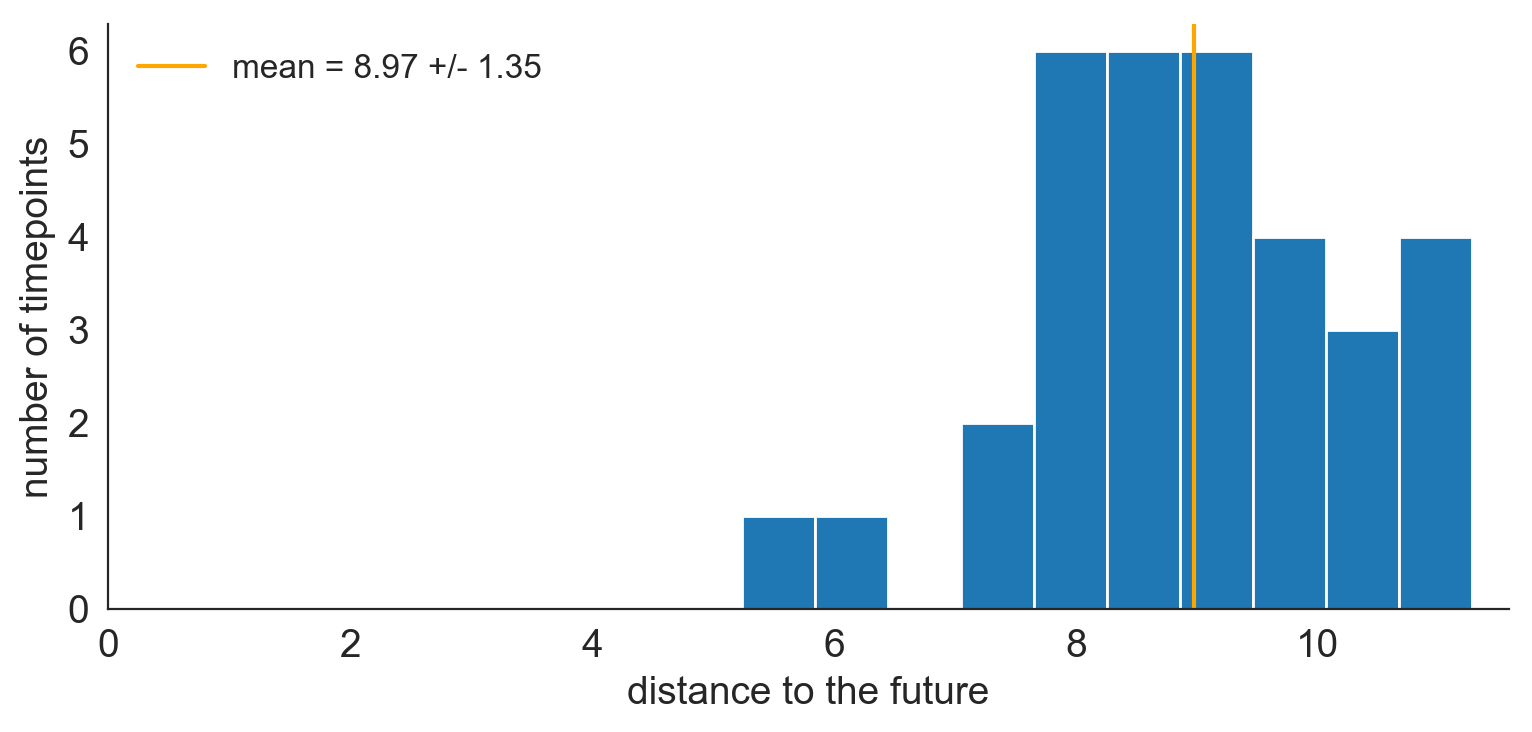

In [41]:
naive_simulated_validation_set = (
    (simulated_errors_by_time_df["predictors"] == "naive") & (simulated_errors_by_time_df["error_type"] == "validation")
)
naive_simulated_errors_by_time_df = simulated_errors_by_time_df[naive_simulated_validation_set]["validation_error"]

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(naive_simulated_errors_by_time_df, bins=10, label=None)
ax.set_xlabel("distance to the future")
ax.set_ylabel("number of timepoints")

mean_y = naive_simulated_errors_by_time_df.mean()
std_y = naive_simulated_errors_by_time_df.std()
ax.axvline(
    x=mean_y,
    color="orange",
    label="mean = %.2f +/- %.2f" % (mean_y, std_y)
)
ax.legend(
    frameon=False
)
ax.set_xlim(left=0)

plt.tight_layout()
plt.savefig("../manuscript/figures/distance-of-simulated-populations-between-timepoints.png")

### Natural populations

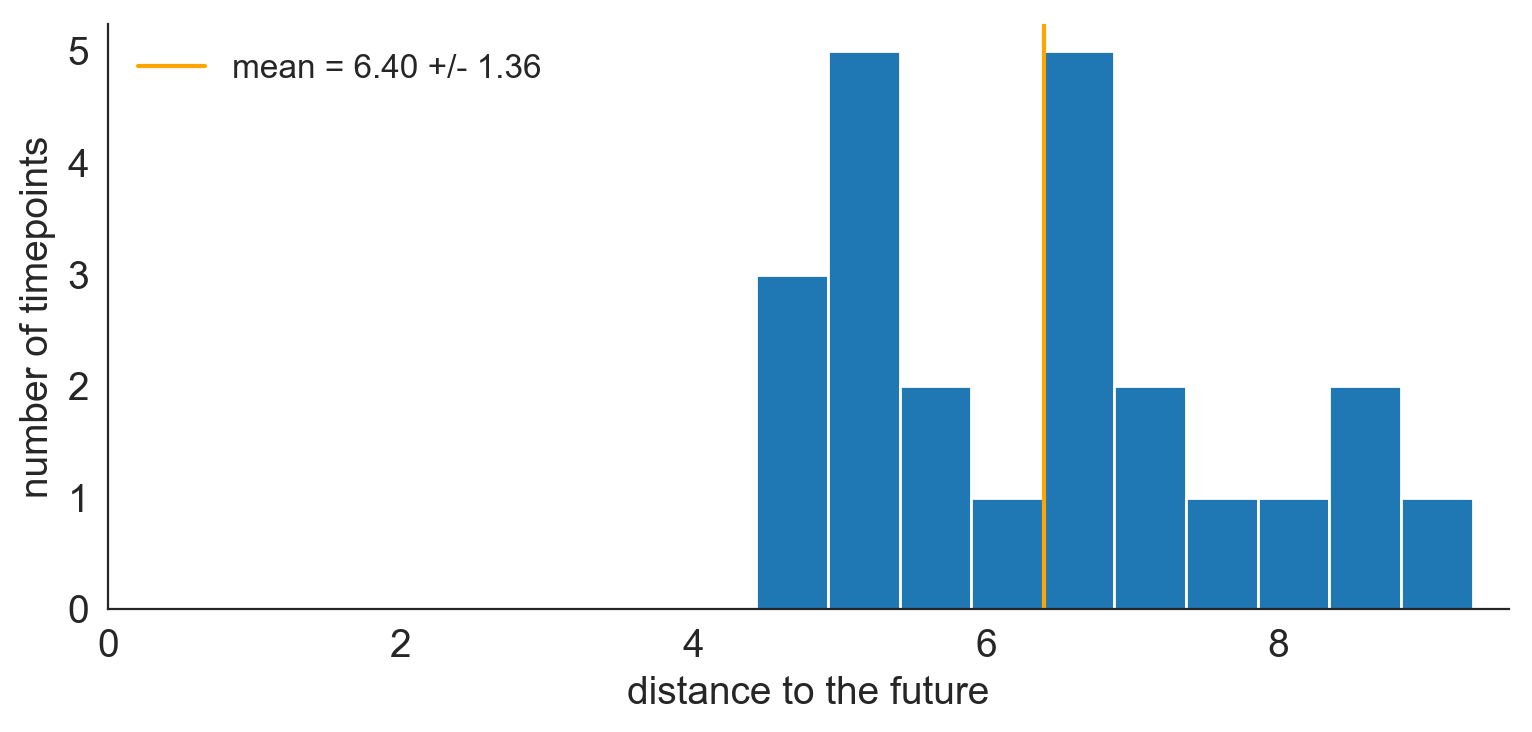

In [191]:
naive_natural_validation_set = (
    (natural_errors_by_time_df["predictors"] == "naive") & (natural_errors_by_time_df["error_type"] == "validation")
)
naive_natural_errors_by_time_df = natural_errors_by_time_df[naive_natural_validation_set]["validation_error"]

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(naive_natural_errors_by_time_df, bins=10, label=None)
ax.set_xlabel("distance to the future")
ax.set_ylabel("number of timepoints")

mean_y = naive_natural_errors_by_time_df.mean()
std_y = naive_natural_errors_by_time_df.std()
ax.axvline(
    x=mean_y,
    color="orange",
    label="mean = %.2f +/- %.2f" % (mean_y, std_y)
)
ax.legend(
    frameon=False
)
ax.set_xlim(left=0)

plt.tight_layout()
#plt.savefig("../manuscript/figures/distance-of-natural-populations-between-timepoints.png")

### Luksza and Lassig populations

In [ ]:
naive_luksza_errors_by_time_df = luksza_errors_by_time_df[luksza_errors_by_time_df["predictors"] == "naive"]["validation_error"]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.hist(naive_luksza_errors_by_time_df, bins=10)
ax.set_xlabel("distance to the future")
ax.set_ylabel("number of timepoints")

mean_y = naive_luksza_errors_by_time_df.mean()
std_y = naive_luksza_errors_by_time_df.std()
ax.axvline(
    x=mean_y,
    color="orange"
)

ax.text(
    0.5,
    0.8,
    "mean = %.2f +/- %.2f" % (mean_y, std_y),
    transform=ax.transAxes,
    fontsize=12,
    horizontalalignment="left"
)

plt.tight_layout()
plt.savefig("../manuscript/figures/distance-of-luksza-lassig-populations-between-timepoints.png")

## Figure 2: Summary of models for simulated populations

In [321]:
simulated_errors_by_time_df["model"] = simulated_errors_by_time_df["predictors"].apply(
    lambda predictor: " + ".join([name_by_predictor.get(predictor_name, predictor_name) for predictor_name in predictor.split("-")])
)

In [322]:
simulated_errors_by_time_df["model_better_than_naive"] = (simulated_errors_by_time_df["model_improvement"] > 0)
simulated_errors_by_time_df["relative_improvement"] = (
    simulated_errors_by_time_df["validation_error"] / simulated_errors_by_time_df["null_validation_error"]
) - 1.0

In [323]:
simulated_errors_by_time_df.head()

null_validation_error predictors  validation_error  validation_n  \
0               8.870808      naive          8.870808           630   
1               8.351673      naive          8.351673           630   
2              10.027961      naive         10.027961           630   
3              11.031343      naive         11.031343           630   
4               8.814196      naive          8.814196           630   

  validation_timepoint       type              sample  error_type  \
0           2023-10-01  simulated  simulated_sample_3  validation   
1           2024-04-01  simulated  simulated_sample_3  validation   
2           2024-10-01  simulated  simulated_sample_3  validation   
3           2025-04-01  simulated  simulated_sample_3  validation   
4           2025-10-01  simulated  simulated_sample_3  validation   

   model_improvement  log2_model_improvement  relative_improvement  model  \
0                0.0                     0.0                   0.0  naive   
1                0.0                     0.0                   0.0  naive   
2                0.0                     0.0                   0.0  naive   
3                0.0                     0.0                   0.0  naive   
4                0.0                     0.0                   0.0  naive   

   model_better_than_naive  
0                    False  
1                    False  
2                    False  
3                    False  
4                    False

In [327]:
simulated_errors_by_time_df.groupby("model").aggregate({"model_improvement": "sum"}).sort_values("model_improvement", ascending=False)

model_improvement
model                                                            
true fitness                                           102.772174
LBI + non-epitope mutations                             93.559506
LBI                                                     72.758467
epitope cross-immunity + non-epitope mutations          41.118099
non-epitope mutations                                   40.558269
delta frequency                                         35.752233
epitope cross-immunity                                   0.109213
naive                                                    0.000000

In [47]:
simulated_validation_errors_by_time_df = simulated_errors_by_time_df.query("error_type == 'validation'").copy()

In [48]:
simulated_model_selection = simulated_validation_errors_by_time_df.groupby("model").aggregate({
    "model_improvement": ["mean", "std"],
    "model_better_than_naive": ["sum", "mean"]
}).query("model != 'naive'").sort_values(("model_improvement", "mean"), ascending=False)

simulated_model_selection.loc[:, ("model_better_than_naive", "sum")] = simulated_model_selection[("model_better_than_naive", "sum")].astype(int)

In [49]:
columns = ["model", "model_improvement_mean", "model_improvement_std", "model_better_count", "model_better_proportion"]
simulated_model_selection = np.around(simulated_model_selection, 2).reset_index()
simulated_model_selection.columns = columns

In [50]:
simulated_model_selection["model_improvement"] = simulated_model_selection.apply(
    lambda row: "%.2f +/- %.2f" % (row["model_improvement_mean"], row["model_improvement_std"]),
    axis=1
)

In [51]:
simulated_model_selection["model_better"] = simulated_model_selection.apply(
    lambda row: "%i (%i\%%)" % (row["model_better_count"], int(row["model_better_proportion"] * 100)),
    axis=1
)

In [52]:
simulated_model_selection = simulated_model_selection.loc[:, ["model", "model_improvement", "model_better"]].copy()

In [53]:
simulated_model_selection.columns = [
    "Model",
    "\makecell{Distance closer \\\\ to future (AAs)}",
    "\makecell{Model $>$ naive \\\\ (N=%i)}" % simulated_validation_errors_by_time_df["validation_timepoint"].unique().shape[0]
]

In [54]:
simulated_model_selection

Model  \
0                                    true fitness   
1                     LBI + non-epitope mutations   
2                                             LBI   
3                                 delta frequency   
4                           non-epitope mutations   
5  epitope cross-immunity + non-epitope mutations   
6                          epitope cross-immunity   

  \makecell{Distance closer \\ to future (AAs)}  \
0                                 2.16 +/- 1.19   
1                                 1.74 +/- 1.02   
2                                 1.41 +/- 1.30   
3                                 0.85 +/- 0.92   
4                                 0.71 +/- 0.58   
5                                 0.70 +/- 0.60   
6                                 0.00 +/- 0.03   

  \makecell{Model $>$ naive \\ (N=33)}  
0                            32 (97\%)  
1                            32 (97\%)  
2                            29 (88\%)  
3                            26 (79\%)  
4                            29 (88\%)  
5                            28 (85\%)  
6                            18 (55\%)

In [55]:
simulated_model_selection_table = simulated_model_selection.to_latex(index=False, escape=False)

with open("../manuscript/tables/simulated_model_selection.tex", "w") as oh:
    oh.write(simulated_model_selection_table)

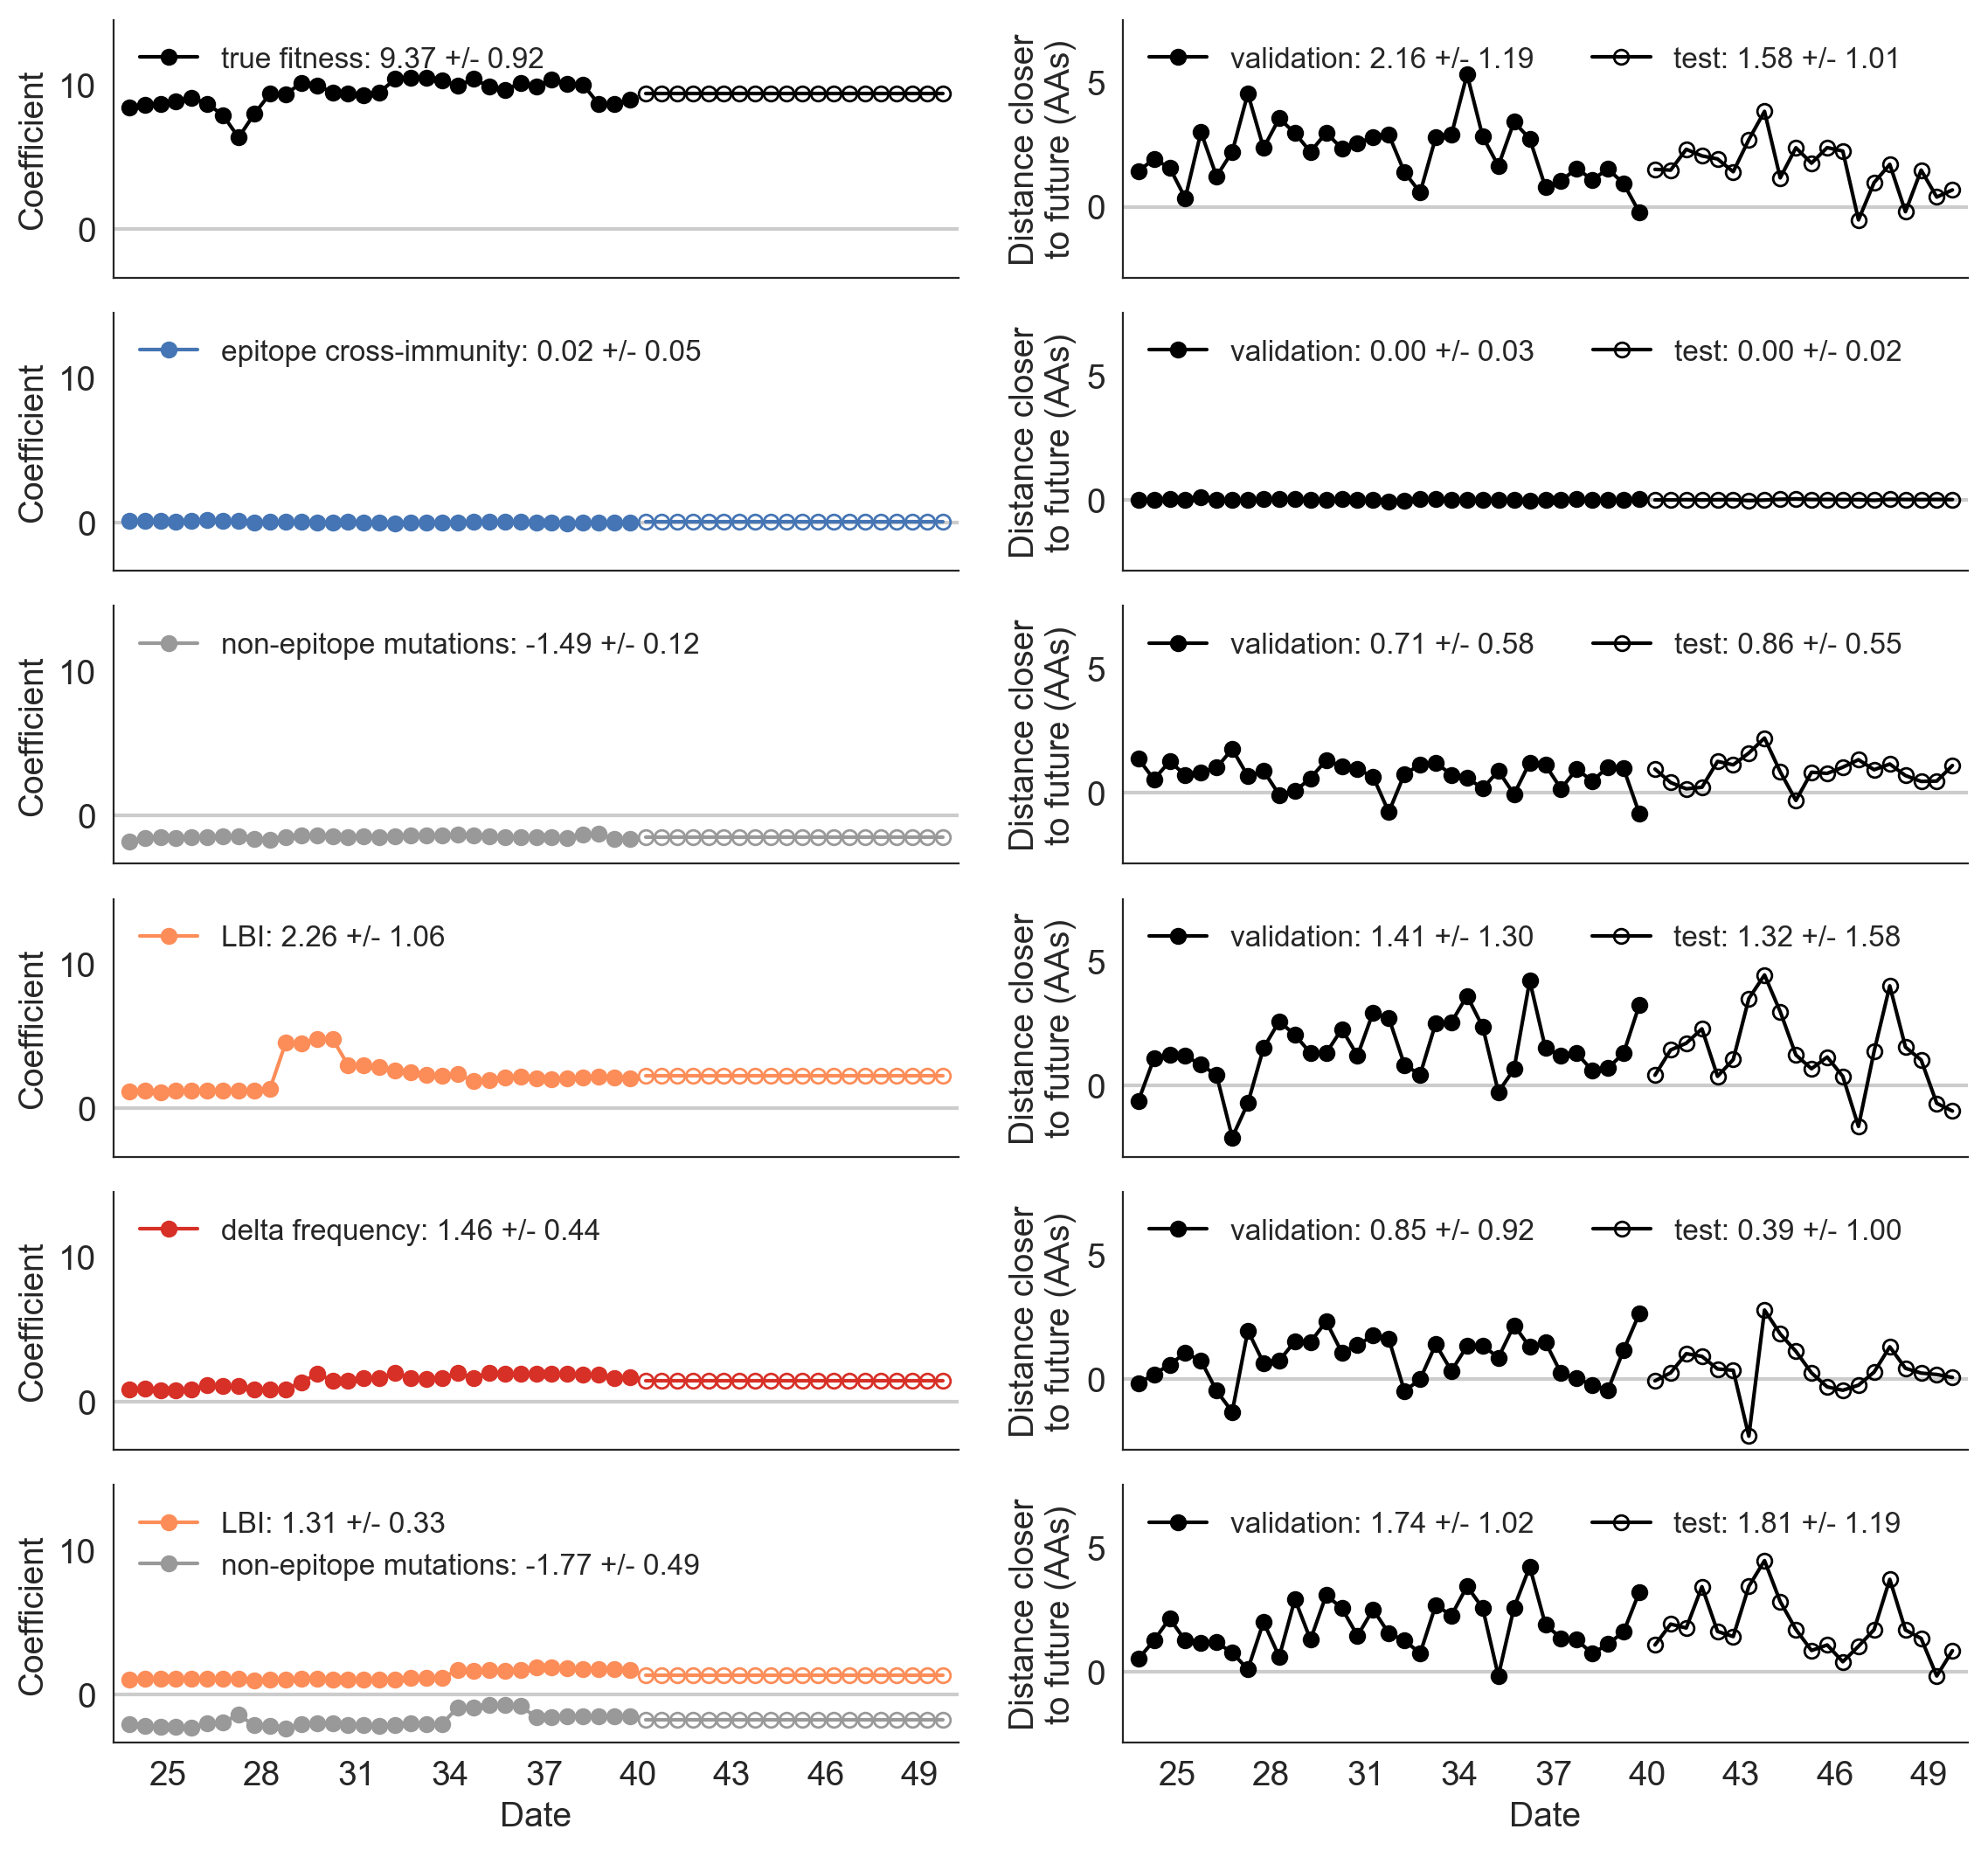

In [281]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    simulated_errors_by_time_df,
    simulated_coefficients_by_time_df,
    get_individual_predictors_for_data_frame(simulated_errors_by_time_df) + ["lbi-ne_star"],
    rotation=0,
    years_fmt_string="%y",
    date_fmt_string="%y-%m",
    height=11,
    hspace=0.1,
    share_y=True,
    max_coefficient=14.5
#    max_normal_error=10
)
plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-simulated-populations.png")

In [319]:
simulated_errors_by_time_df["model_"]

null_validation_error    predictors  validation_error  validation_n  \
0                  8.870808         naive          8.870808           630   
1                  8.351673         naive          8.351673           630   
2                 10.027961         naive         10.027961           630   
3                 11.031343         naive         11.031343           630   
4                  8.814196         naive          8.814196           630   
5                  8.980835         naive          8.980835           630   
6                 10.137932         naive         10.137932           630   
7                 11.224289         naive         11.224289           630   
8                  9.798772         naive          9.798772           630   
9                 10.142376         naive         10.142376           630   
10                 8.827465         naive          8.827465           630   
11                 9.139197         naive          9.139197           630   
12                 8.675749         naive          8.675749           630   
13                 8.897303         naive          8.897303           630   
14                11.213545         naive         11.213545           630   
15                11.274544         naive         11.274544           630   
16                 8.112486         naive          8.112486           630   
17                 7.566834         naive          7.566834           630   
18                 9.075377         naive          9.075377           630   
19                 8.042771         naive          8.042771           630   
20                 9.798735         naive          9.798735           630   
21                10.012824         naive         10.012824           630   
22                 8.239439         naive          8.239439           630   
23                 8.096509         naive          8.096509           630   
24                 7.909487         naive          7.909487           630   
25                 8.868370         naive          8.868370           630   
26                 8.721633         naive          8.721633           630   
27                 6.382107         naive          6.382107           630   
28                 7.457706         naive          7.457706           630   
29                 5.239253         naive          5.239253           630   
...                     ...           ...               ...           ...   
1194               7.671198  ep_x-ne_star          6.655566           630   
1195               8.214752  ep_x-ne_star          7.279544           630   
1196               7.460040  ep_x-ne_star          6.431942           630   
1197               8.131906  ep_x-ne_star          6.842303           630   
1198              10.777043  ep_x-ne_star         10.098656           630   
1199              11.732285  ep_x-ne_star         10.621619           630   
1200              10.930322  ep_x-ne_star         10.208632           630   
1201               7.422700  ep_x-ne_star          6.740731           630   
1202               7.478334  ep_x-ne_star          6.972432           630   
1203               7.239005  ep_x-ne_star          5.659461           630   
1204               7.281744   lbi-ne_star          6.199421           630   
1205               8.078080   lbi-ne_star          6.154594           630   
1206               8.491247   lbi-ne_star          6.723392           630   
1207               9.026759   lbi-ne_star          5.598037           630   
1208               7.665065   lbi-ne_star          6.037503           630   
1209               9.783160   lbi-ne_star          8.360287           630   
1210              12.679029   lbi-ne_star          9.235433           630   
1211              11.094566   lbi-ne_star          6.614163           630   
1212               9.352016   lbi-ne_star          6.519452           630   
1213               7.494298   lbi-ne_star          5.786435           630   
12

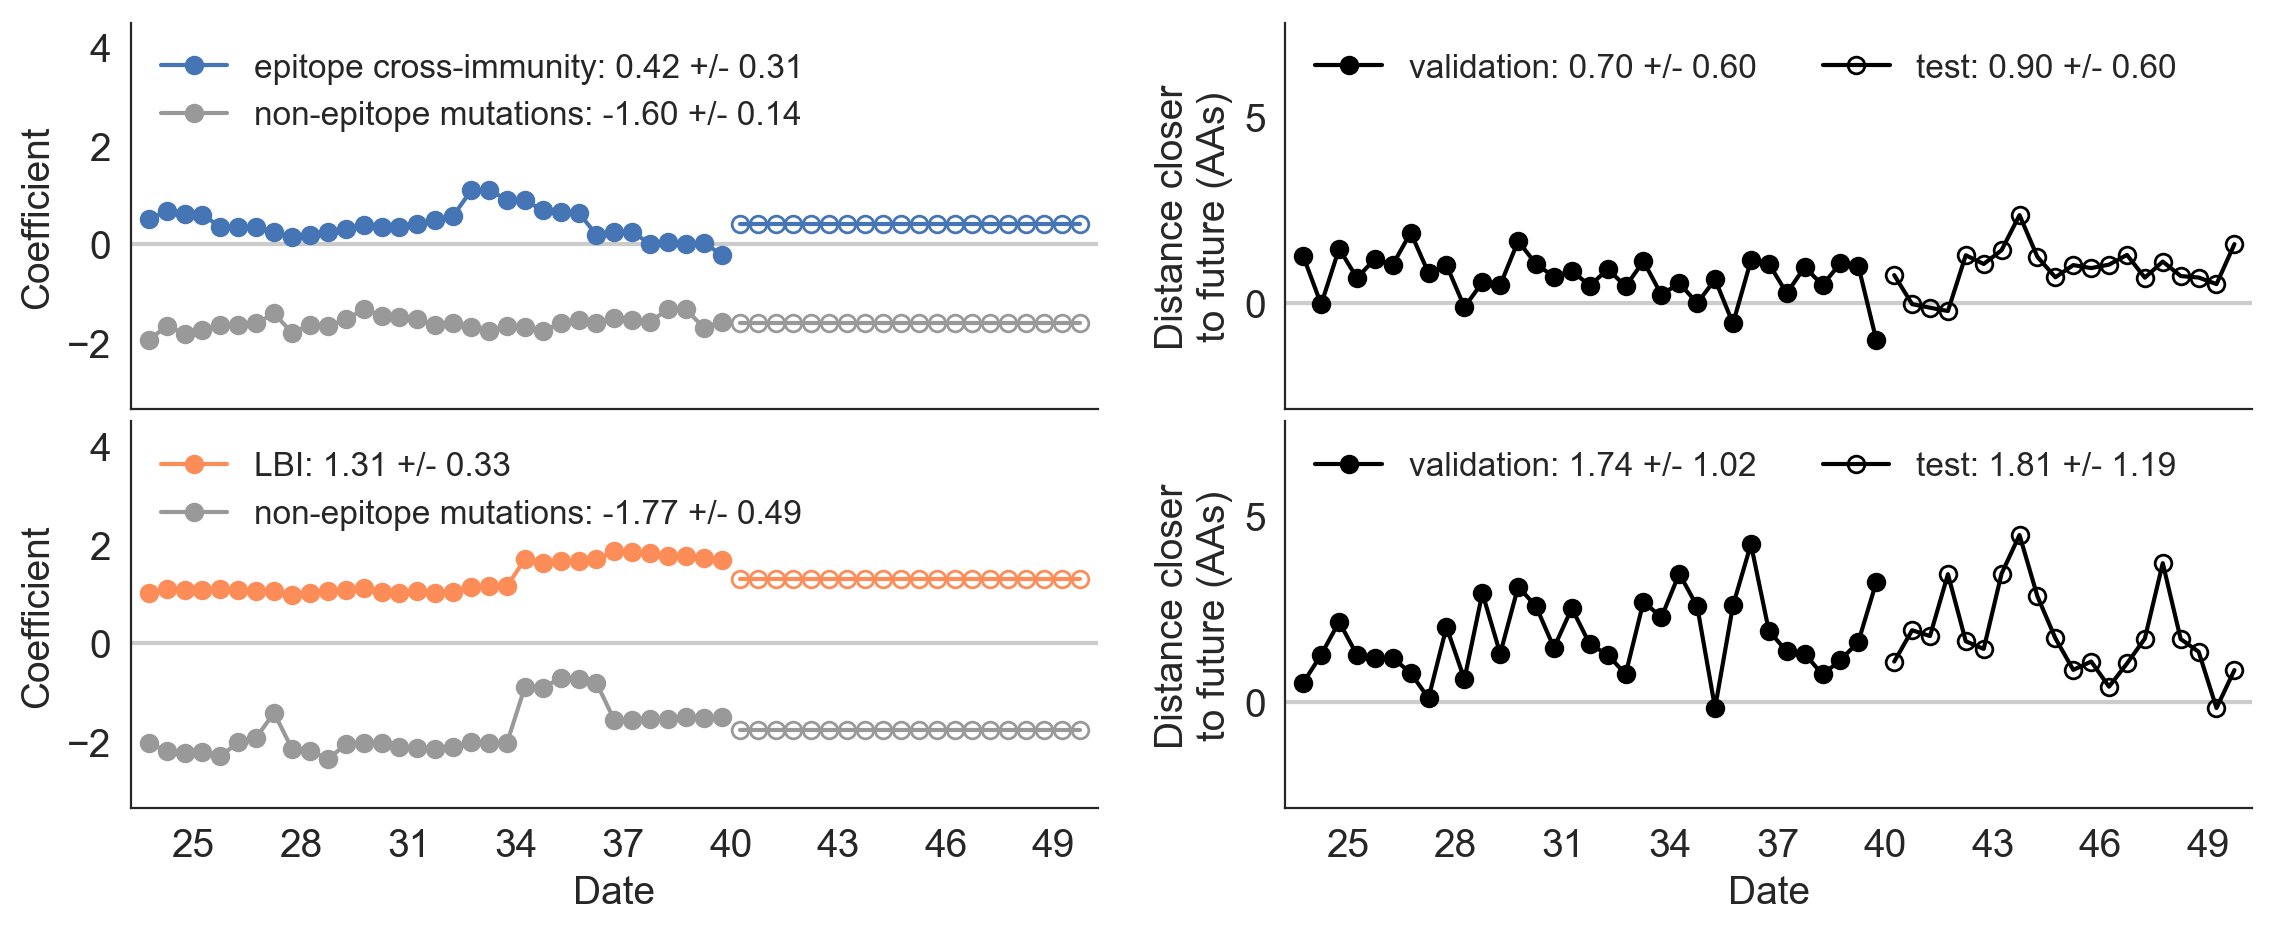

In [282]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    simulated_errors_by_time_df,
    simulated_coefficients_by_time_df,
    get_composite_predictors_for_data_frame(simulated_errors_by_time_df),
    rotation=0,
    years_fmt_string="%y",
    date_fmt_string="%y-%m",
    height=5,
    max_coefficient=4.5
)
plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-simulated-populations.png")

## Figure 3: Summary of models for natural populations

In [328]:
subset_of_individual_predictors = [
    "ep_x",
    "cTiter_x",
    "ne_star",
    "dms_star",
    "lbi",
    "delta_frequency"
]

In [329]:
composite_models = [
    "cTiter_x-ne_star",
    "ne_star-lbi",
    "cTiter_x-ne_star-lbi"
]

In [330]:
natural_errors_by_time_df["validation_timepoint"].unique().shape

(23,)

In [331]:
natural_errors_by_time_df["model"] = natural_errors_by_time_df["predictors"].apply(
    lambda predictor: " + ".join([name_by_predictor.get(predictor_name, predictor_name) for predictor_name in predictor.split("-")])
)

In [332]:
natural_errors_by_time_df["model_better_than_naive"] = (natural_errors_by_time_df["model_improvement"] > 0)
natural_errors_by_time_df["relative_improvement"] = (
    natural_errors_by_time_df["validation_error"] / natural_errors_by_time_df["null_validation_error"]
) - 1.0

In [333]:
natural_validation_errors_by_time_df = natural_errors_by_time_df.query("error_type == 'validation'").copy()

In [334]:
natural_model_selection = natural_validation_errors_by_time_df.groupby(["model", "predictors"]).aggregate({
    "model_improvement": ["mean", "std"],
    "model_better_than_naive": ["sum", "mean"]
}).query("model != 'naive'").sort_values(("model_improvement", "mean"), ascending=False)

natural_model_selection.loc[:, ("model_better_than_naive", "sum")] = natural_model_selection[("model_better_than_naive", "sum")].astype(int)

In [335]:
columns = ["model", "predictors", "model_improvement_mean", "model_improvement_std", "model_better_count", "model_better_proportion"]
natural_model_selection = np.around(natural_model_selection, 2).reset_index()
natural_model_selection.columns = columns

In [336]:
natural_model_selection["model_improvement"] = natural_model_selection.apply(
    lambda row: "%.2f +/- %.2f" % (row["model_improvement_mean"], row["model_improvement_std"]),
    axis=1
)

In [337]:
natural_model_selection["model_better"] = natural_model_selection.apply(
    lambda row: "%i (%i\%%)" % (row["model_better_count"], int(row["model_better_proportion"] * 100)),
    axis=1
)

In [338]:
natural_model_selection

model            predictors  \
0                       non-epitope mutations + LBI           ne_star-lbi   
1                                               LBI                   lbi   
2         HI cross-immunity + non-epitope mutations      cTiter_x-ne_star   
3   HI cross-immunity + non-epitope mutations + LBI  cTiter_x-ne_star-lbi   
4                                           HI tree                cTiter   
5                                 HI cross-immunity              cTiter_x   
6                                   delta frequency       delta_frequency   
7                             non-epitope mutations               ne_star   
8                            Koel epitope mutations                    rb   
9                                       DMS entropy           dms_entropy   
10                                  DMS non-epitope        dms_nonepitope   
11                         linear HI mut phenotypes             cTiterSub   
12                            HI sub cross-immunity           cTiterSub_x   
13                           Wolf epitope mutations               ep_wolf   
14                           DMS mutational effects              dms_star   
15                                epitope mutations                    ep   
16   epitope cross-immunity + non-epitope mutations          ep_x-ne_star   
17                           epitope cross-immunity                  ep_x   

    model_improvement_mean  model_improvement_std  model_better_count  \
0                     0.96                   1.42                  18   
1                     0.72                   1.51                  17   
2                     0.63                   0.79                  18   
3                     0.52                   0.83                  19   
4                     0.40                   0.82                  15   
5                     0.36                   0.65                  17   
6                     0.27                   0.67                  16   
7                     0.26                   0.56                  17   
8                     0.19                   0.25                  19   
9                     0.02                   0.15                  14   
10                   -0.05                   0.15                   7   
11                   -0.06                   0.51                  11   
12                   -0.14                   0.57                  10   
13                   -0.17                   0.31                   5   
14                   -0.35                   1.65                  11   
15                   -0.43                   0.94                   5   
16                   -0.54                   1.39                   6   
17                   -0.66                   1.13                   6   

    model_better_proportion model_improvement model_better  
0                      0.78     0.96 +/- 1.42    18 (78\%)  
1                      0.74     0.72 +/- 1.51    17 (74\%)  
2                      0.78     0.63 +/- 0.79    18 (78\%)  
3                      0.83     0.52 +/- 0.83    19 (83\%)  
4                      0.65     0.40 +/- 0.82    15 (65\%)  
5                      0.74     0.36 +/- 0.65    17 (74\%)  
6                      0.70     0.27 +/- 0.67    16 (70\%)  
7                      0.74     0.26 +/- 0.56    17 (74\%)  
8                      0.83     0.19 +/- 0.25    19 (83\%)  
9                      0.61     0.02 +/- 0.15    14 (61\%)  
10                     0.30    -0.05 +/- 0.15     7 (30\%)  
11                     0.48    -0.06 +/- 0.51    11 (48\%)  
12                     0.43    -0.14 +/- 0.57    10 (43\%)  
13                     0.22    -0.17 +/- 0.31     5 (22\%)  
14                     0.48    -0.35 +/- 1.65    11 (48\%)  
15                     0.22    -0.43 +/- 0.94     5 (22\%)  
16                     0.26    -0.54 +/- 1.39     6 (26\%)  
17                     0.26    -0.66 +/- 1.13     6 (26\%)

In [314]:
subset_natural_model_selection = natural_model_selection.loc[
    natural_model_selection["predictors"].isin(subset_of_individual_predictors + composite_models),
    ["model", "model_improvement", "model_better"]
].copy()

In [315]:
subset_natural_model_selection.columns = [
    "Model",
    "\makecell{Distance closer \\\\ to future (AAs)}",
    "\makecell{Model $>$ naive \\\\ (N=%i)}" % natural_validation_errors_by_time_df["validation_timepoint"].unique().shape[0]
]

In [316]:
subset_natural_model_selection

Model  \
0                       non-epitope mutations + LBI   
1                                               LBI   
2         HI cross-immunity + non-epitope mutations   
3   HI cross-immunity + non-epitope mutations + LBI   
5                                 HI cross-immunity   
6                                   delta frequency   
7                             non-epitope mutations   
14                           DMS mutational effects   
17                           epitope cross-immunity   

   \makecell{Distance closer \\ to future (AAs)}  \
0                                  0.96 +/- 1.42   
1                                  0.72 +/- 1.51   
2                                  0.63 +/- 0.79   
3                                  0.52 +/- 0.83   
5                                  0.36 +/- 0.65   
6                                  0.27 +/- 0.67   
7                                  0.26 +/- 0.56   
14                                -0.35 +/- 1.65   
17                                -0.66 +/- 1.13   

   \makecell{Model $>$ naive \\ (N=23)}  
0                             18 (78\%)  
1                             17 (74\%)  
2                             18 (78\%)  
3                             19 (83\%)  
5                             17 (74\%)  
6                             16 (70\%)  
7                             17 (74\%)  
14                            11 (48\%)  
17                             6 (26\%)

In [317]:
subset_natural_model_selection_table = subset_natural_model_selection.to_latex(index=False, escape=False)

with open("../manuscript/tables/natural_model_selection.tex", "w") as oh:
    oh.write(subset_natural_model_selection_table)

Make a separate table with all models including those we do not discuss in the manuscript.

In [318]:
complete_natural_model_selection = natural_model_selection.loc[:, ["model", "model_improvement", "model_better"]].copy()
complete_natural_model_selection.columns = [
    "Model",
    "\makecell{Distance closer \\\\ to future (AAs)}",
    "\makecell{Model $>$ naive \\\\ (N=%i)}" % natural_validation_errors_by_time_df["validation_timepoint"].unique().shape[0]
]

complete_natural_model_selection_table = complete_natural_model_selection.to_latex(index=False, escape=False)

with open("../manuscript/tables/complete_natural_model_selection.tex", "w") as oh:
    oh.write(complete_natural_model_selection_table)

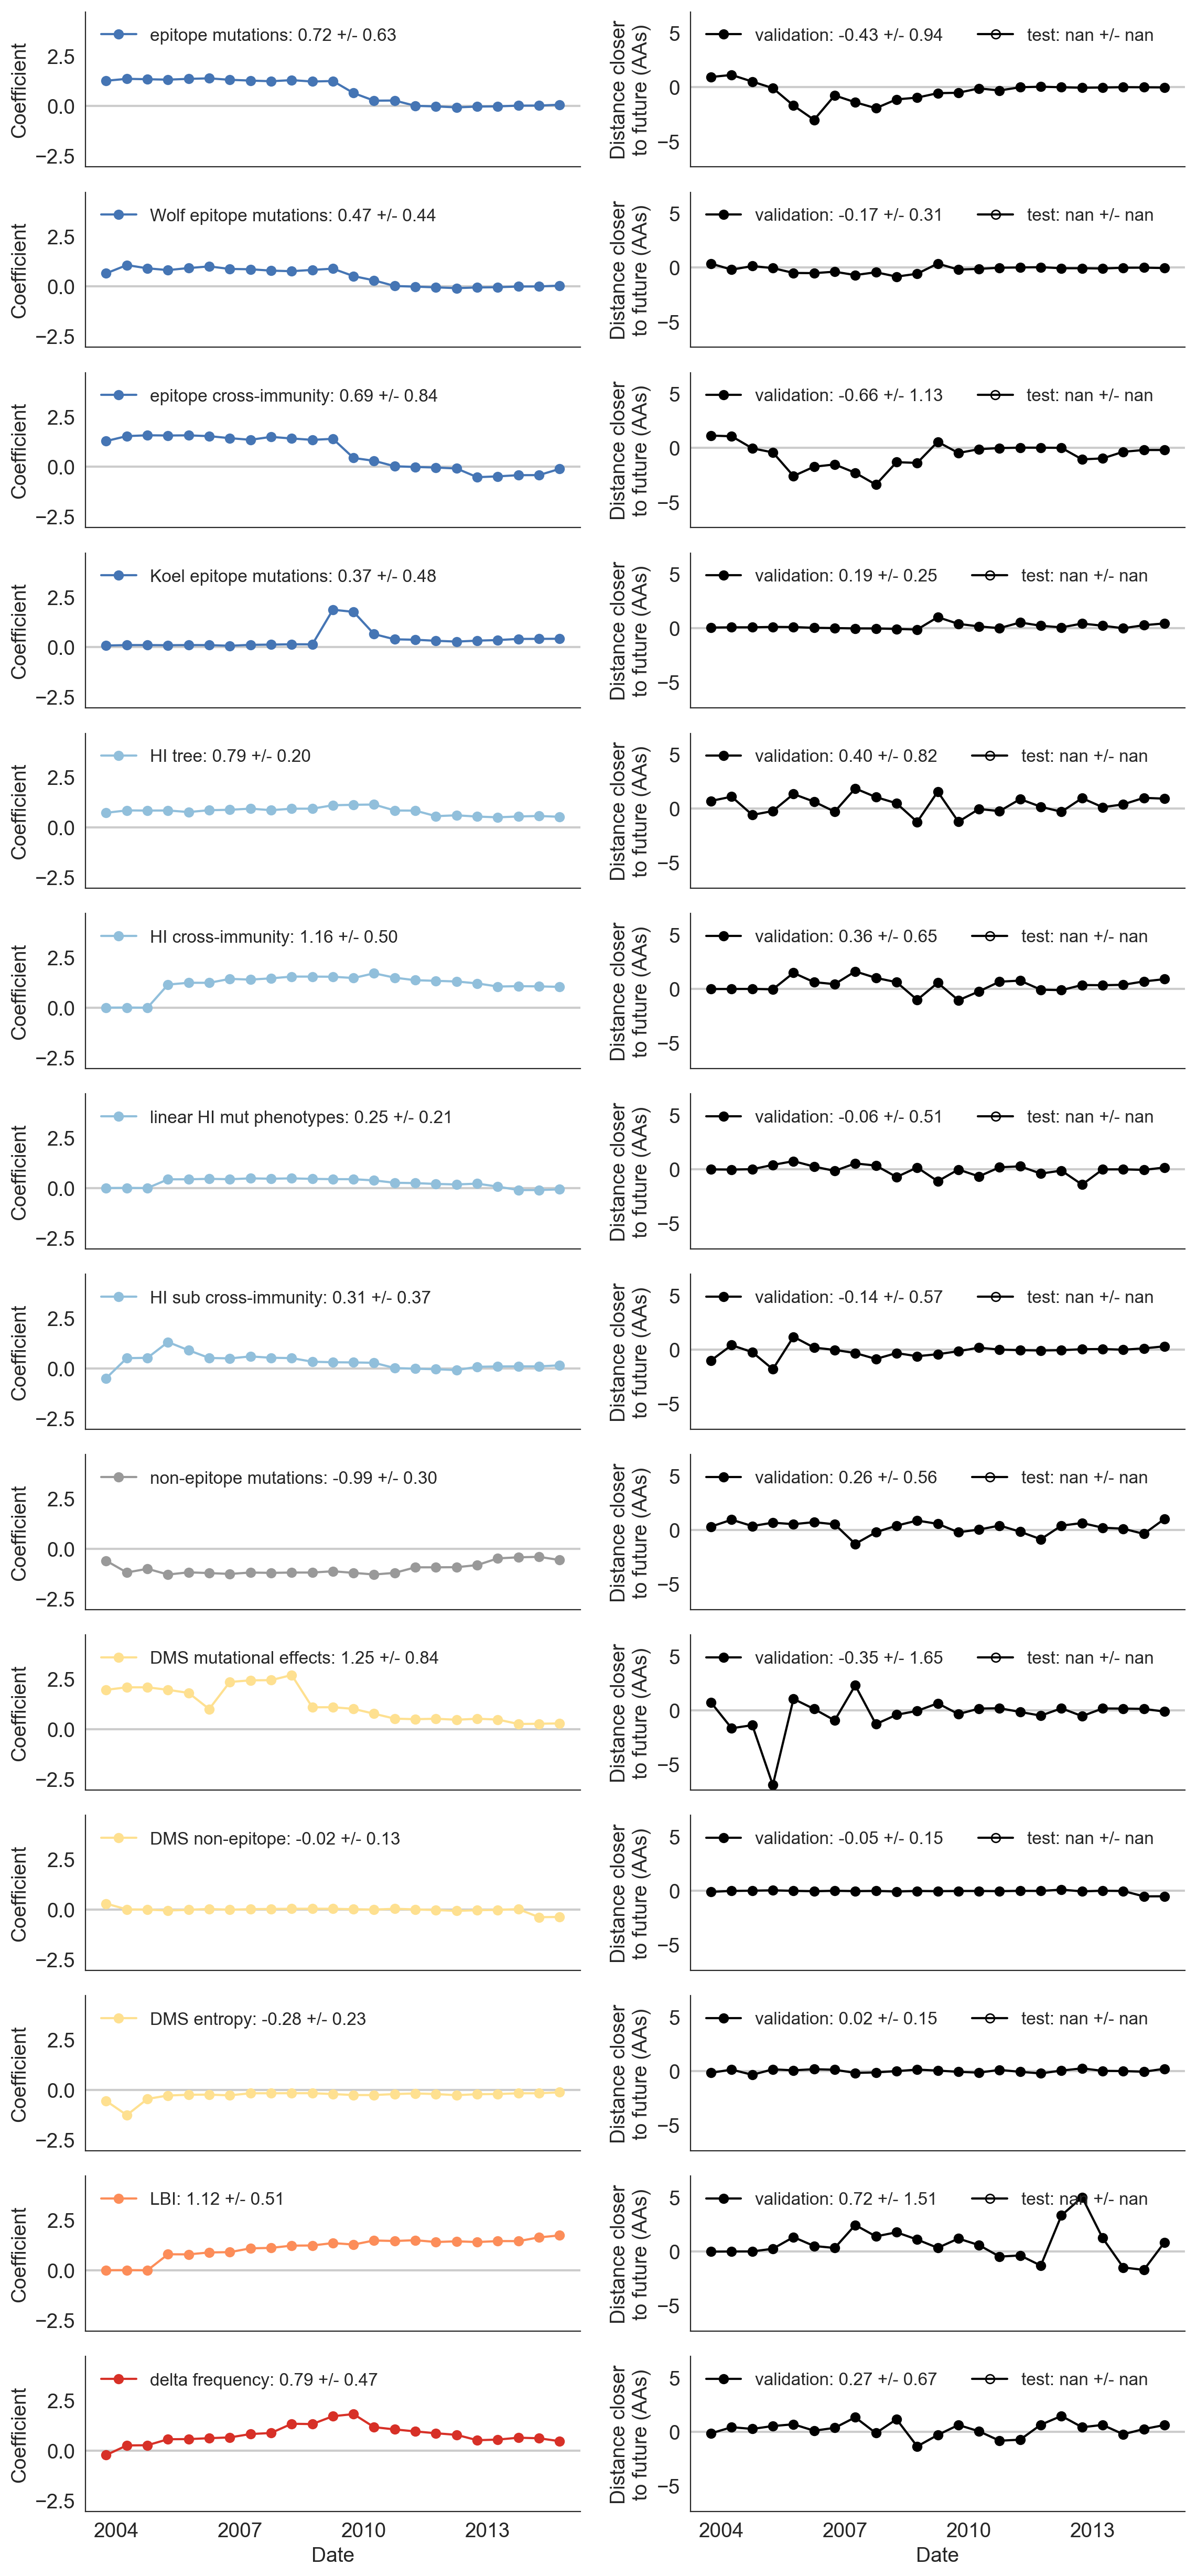

In [283]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    get_individual_predictors_for_data_frame(natural_errors_by_time_df),
    height=25,
    rotation=0
)
plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-natural-populations-all-individual-predictors.png")

In [284]:
natural_errors_by_time_df.query("predictors == 'dms_star' & model_improvement > 1")

null_validation_error predictors  validation_error  validation_n  \
631               5.347614   dms_star          4.274793           469   
634               5.740692   dms_star          3.419894           431   

    validation_timepoint     type                                sample  \
631           2005-10-01  natural  natural_sample_1_with_90_vpm_sliding   
634           2007-04-01  natural  natural_sample_1_with_90_vpm_sliding   

     error_type  model_improvement  log2_model_improvement  \
631  validation           1.072821                0.323041   
634  validation           2.320798                0.747273   

     relative_improvement  
631              0.200617  
634              0.404271

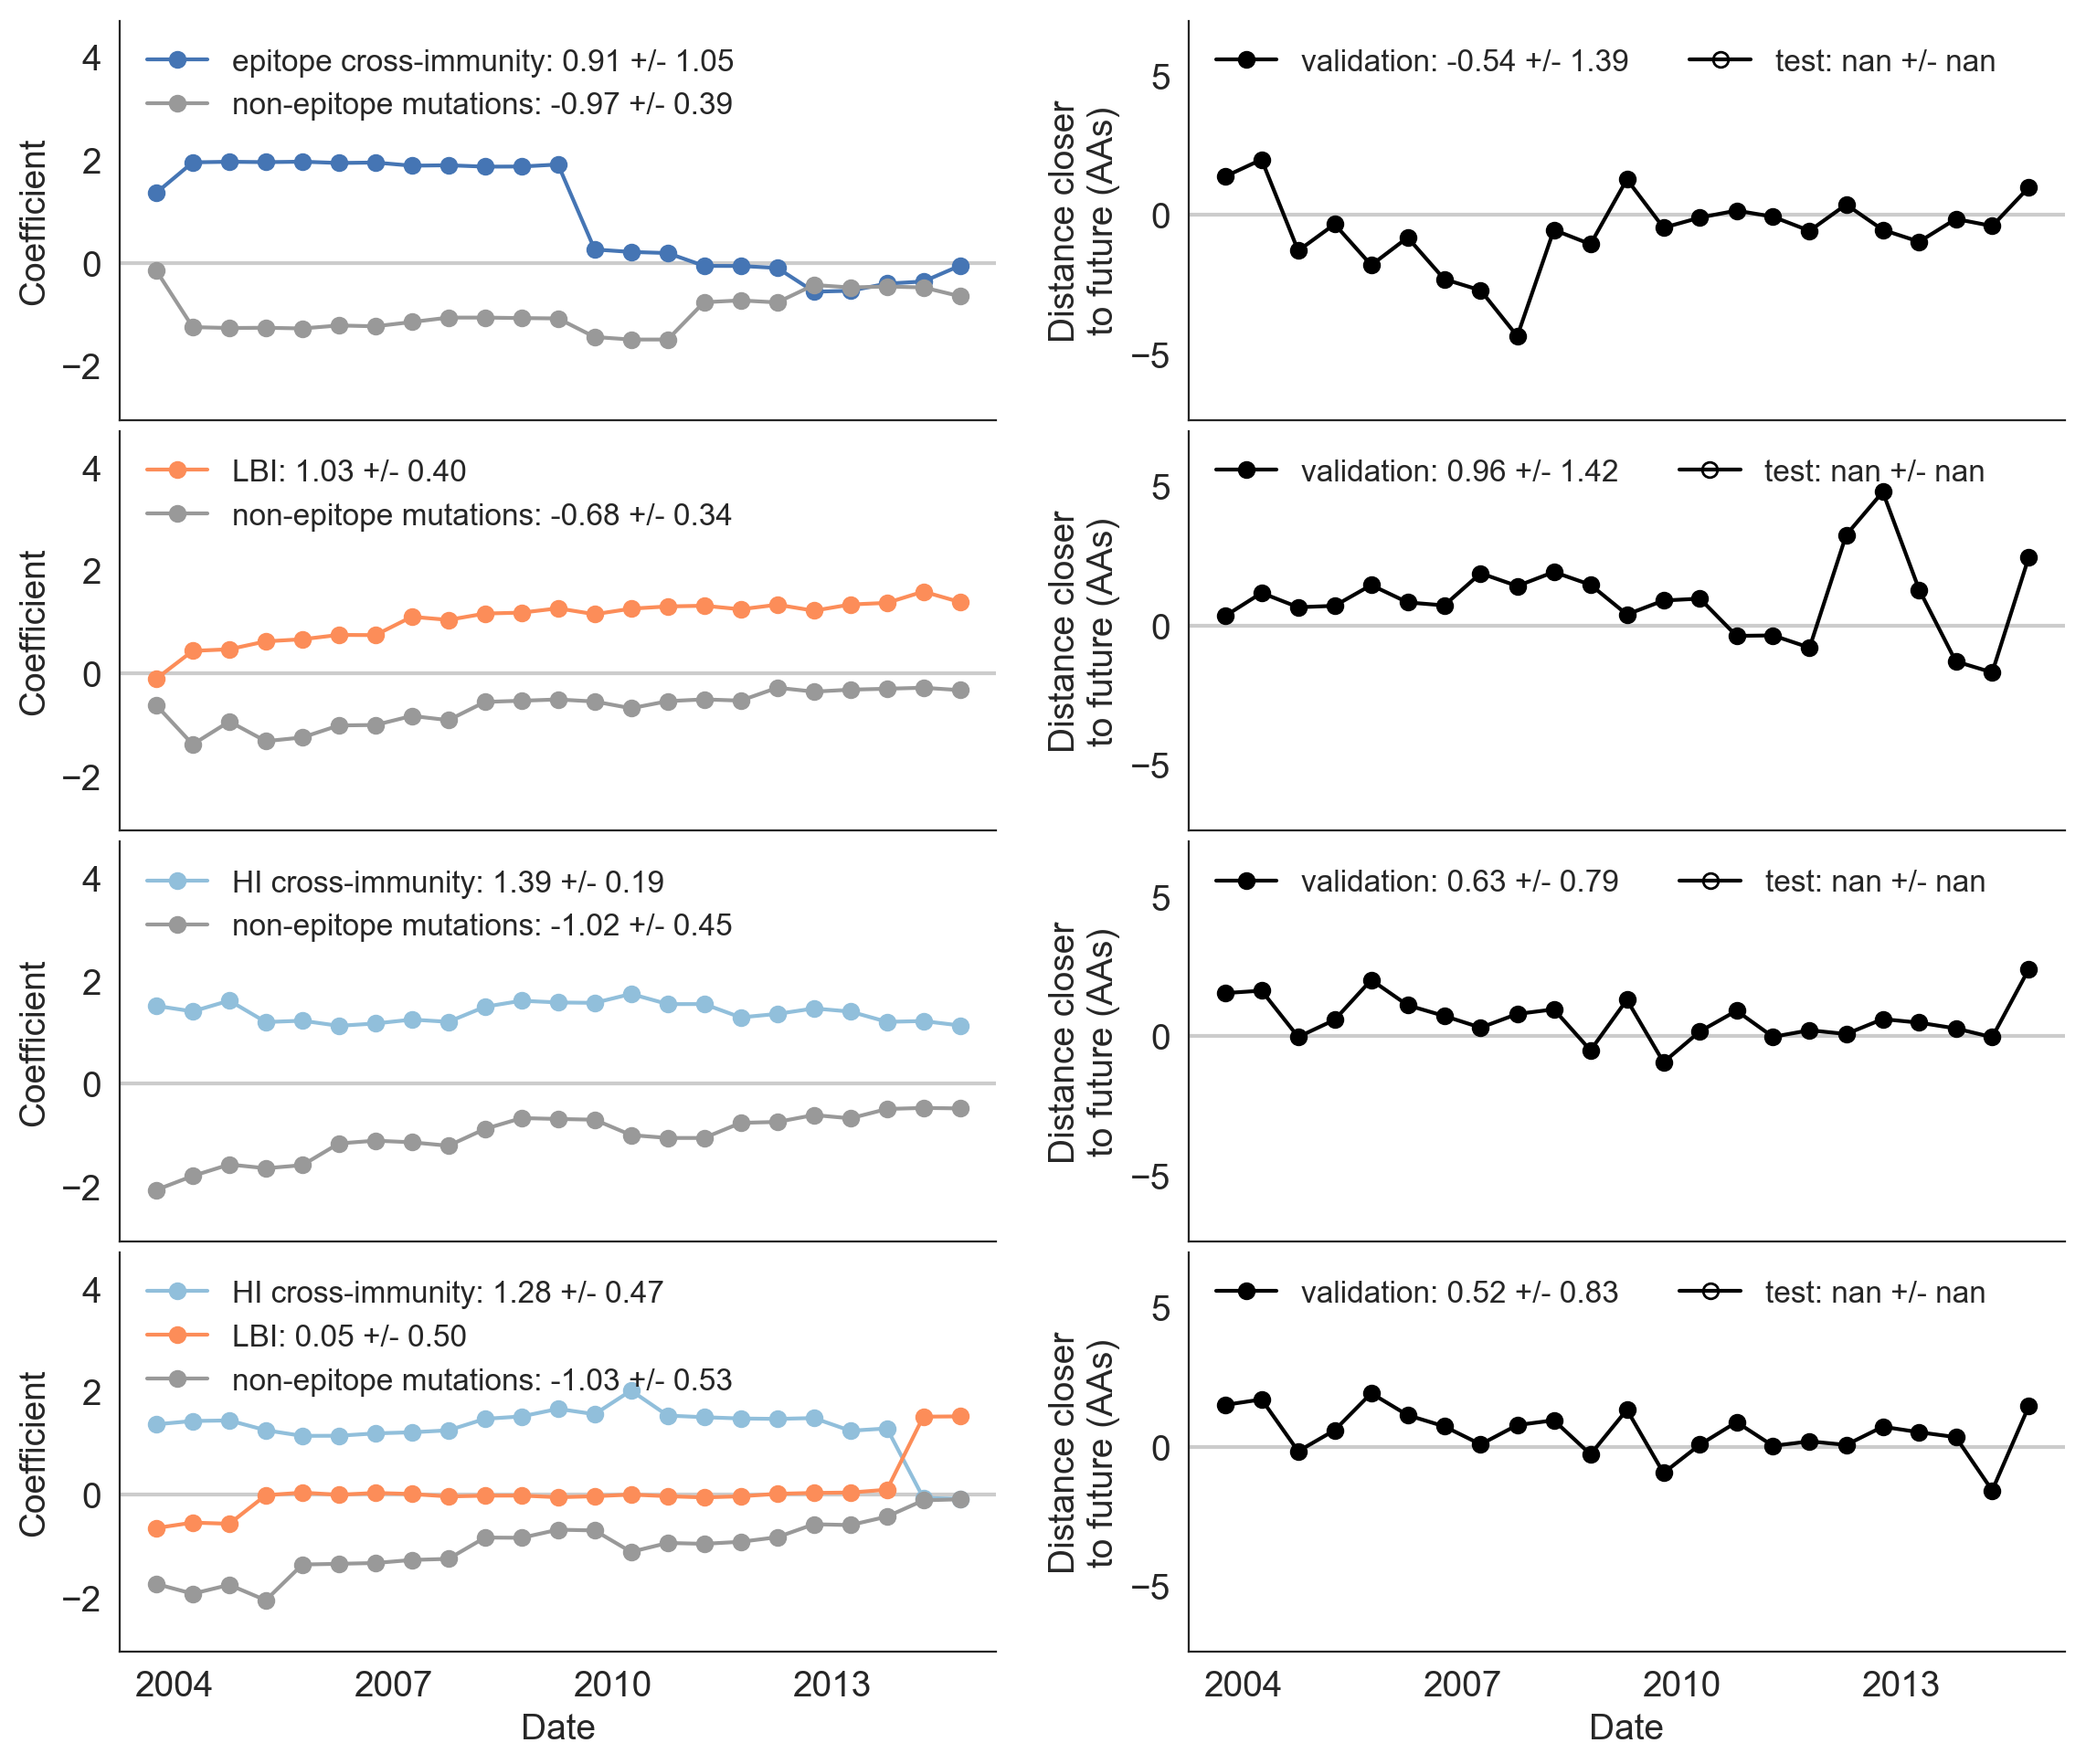

In [285]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    get_composite_predictors_for_data_frame(natural_errors_by_time_df),
    height=10,
    rotation=0
)
plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-natural-populations-all-composite-predictors.png")

### Individual models

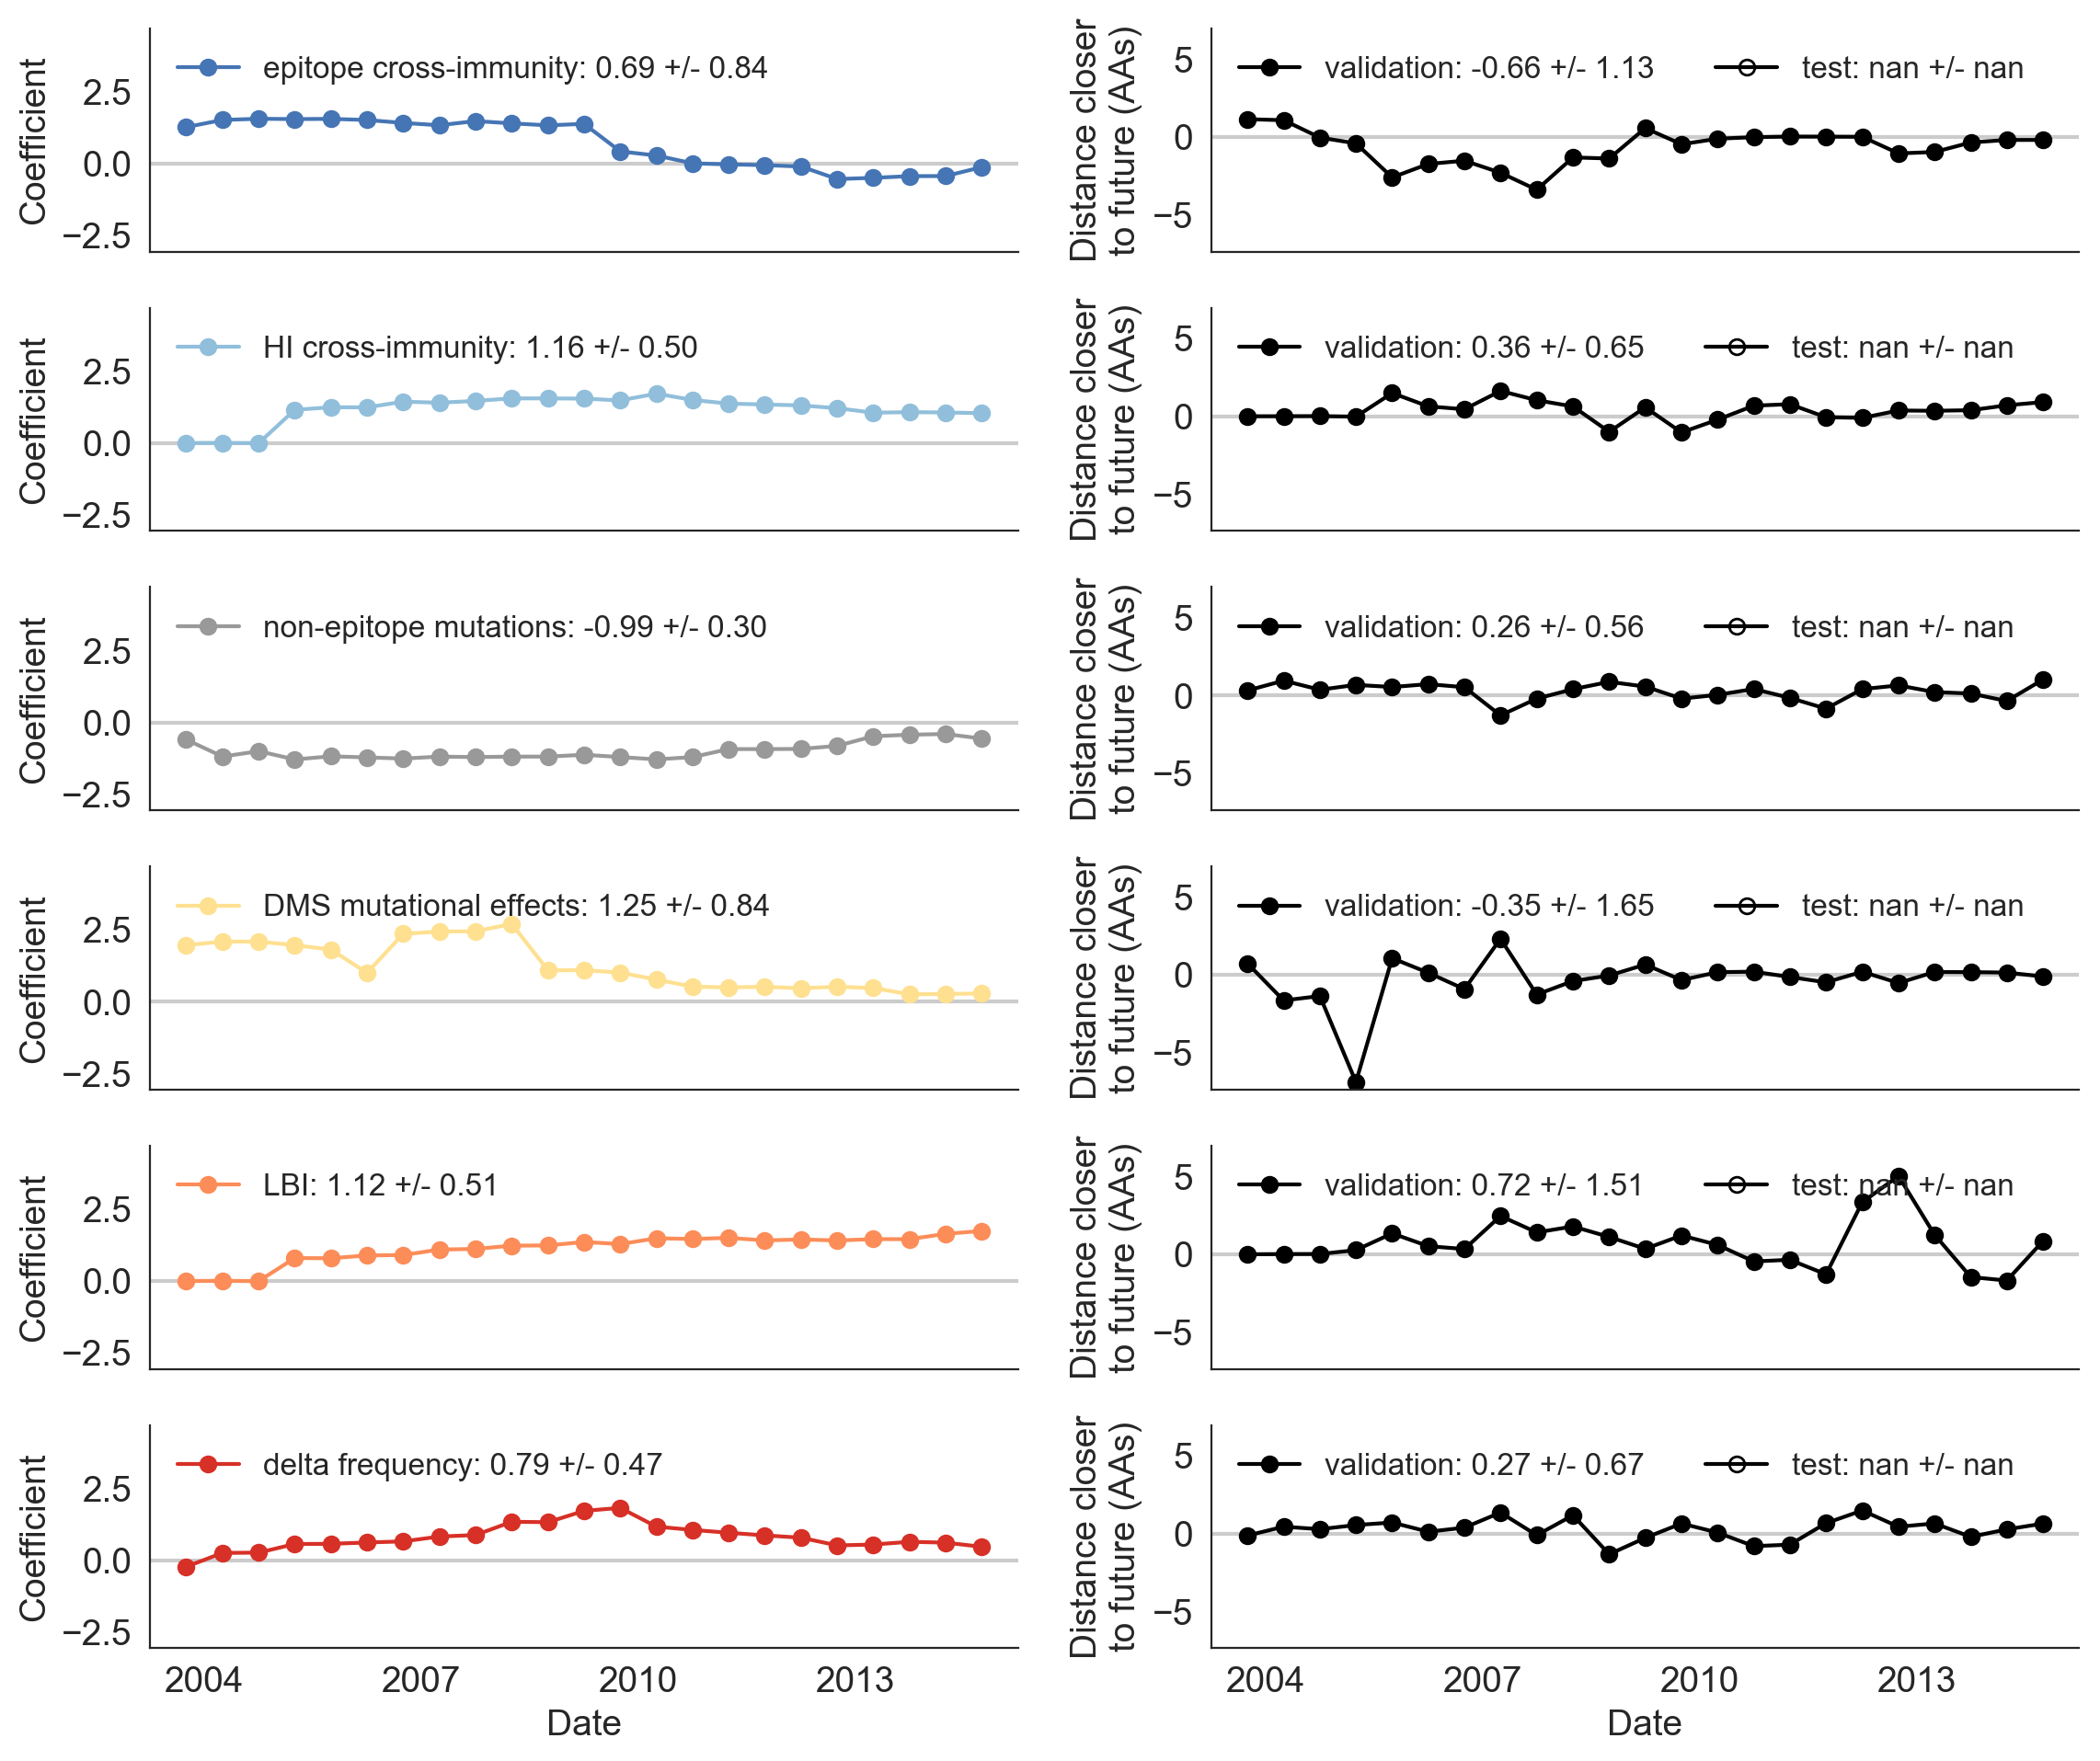

In [287]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    subset_of_individual_predictors,
    height=10,
    rotation=0
)
plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-natural-populations.png")

### Within category model comparisons

#### Antigenic

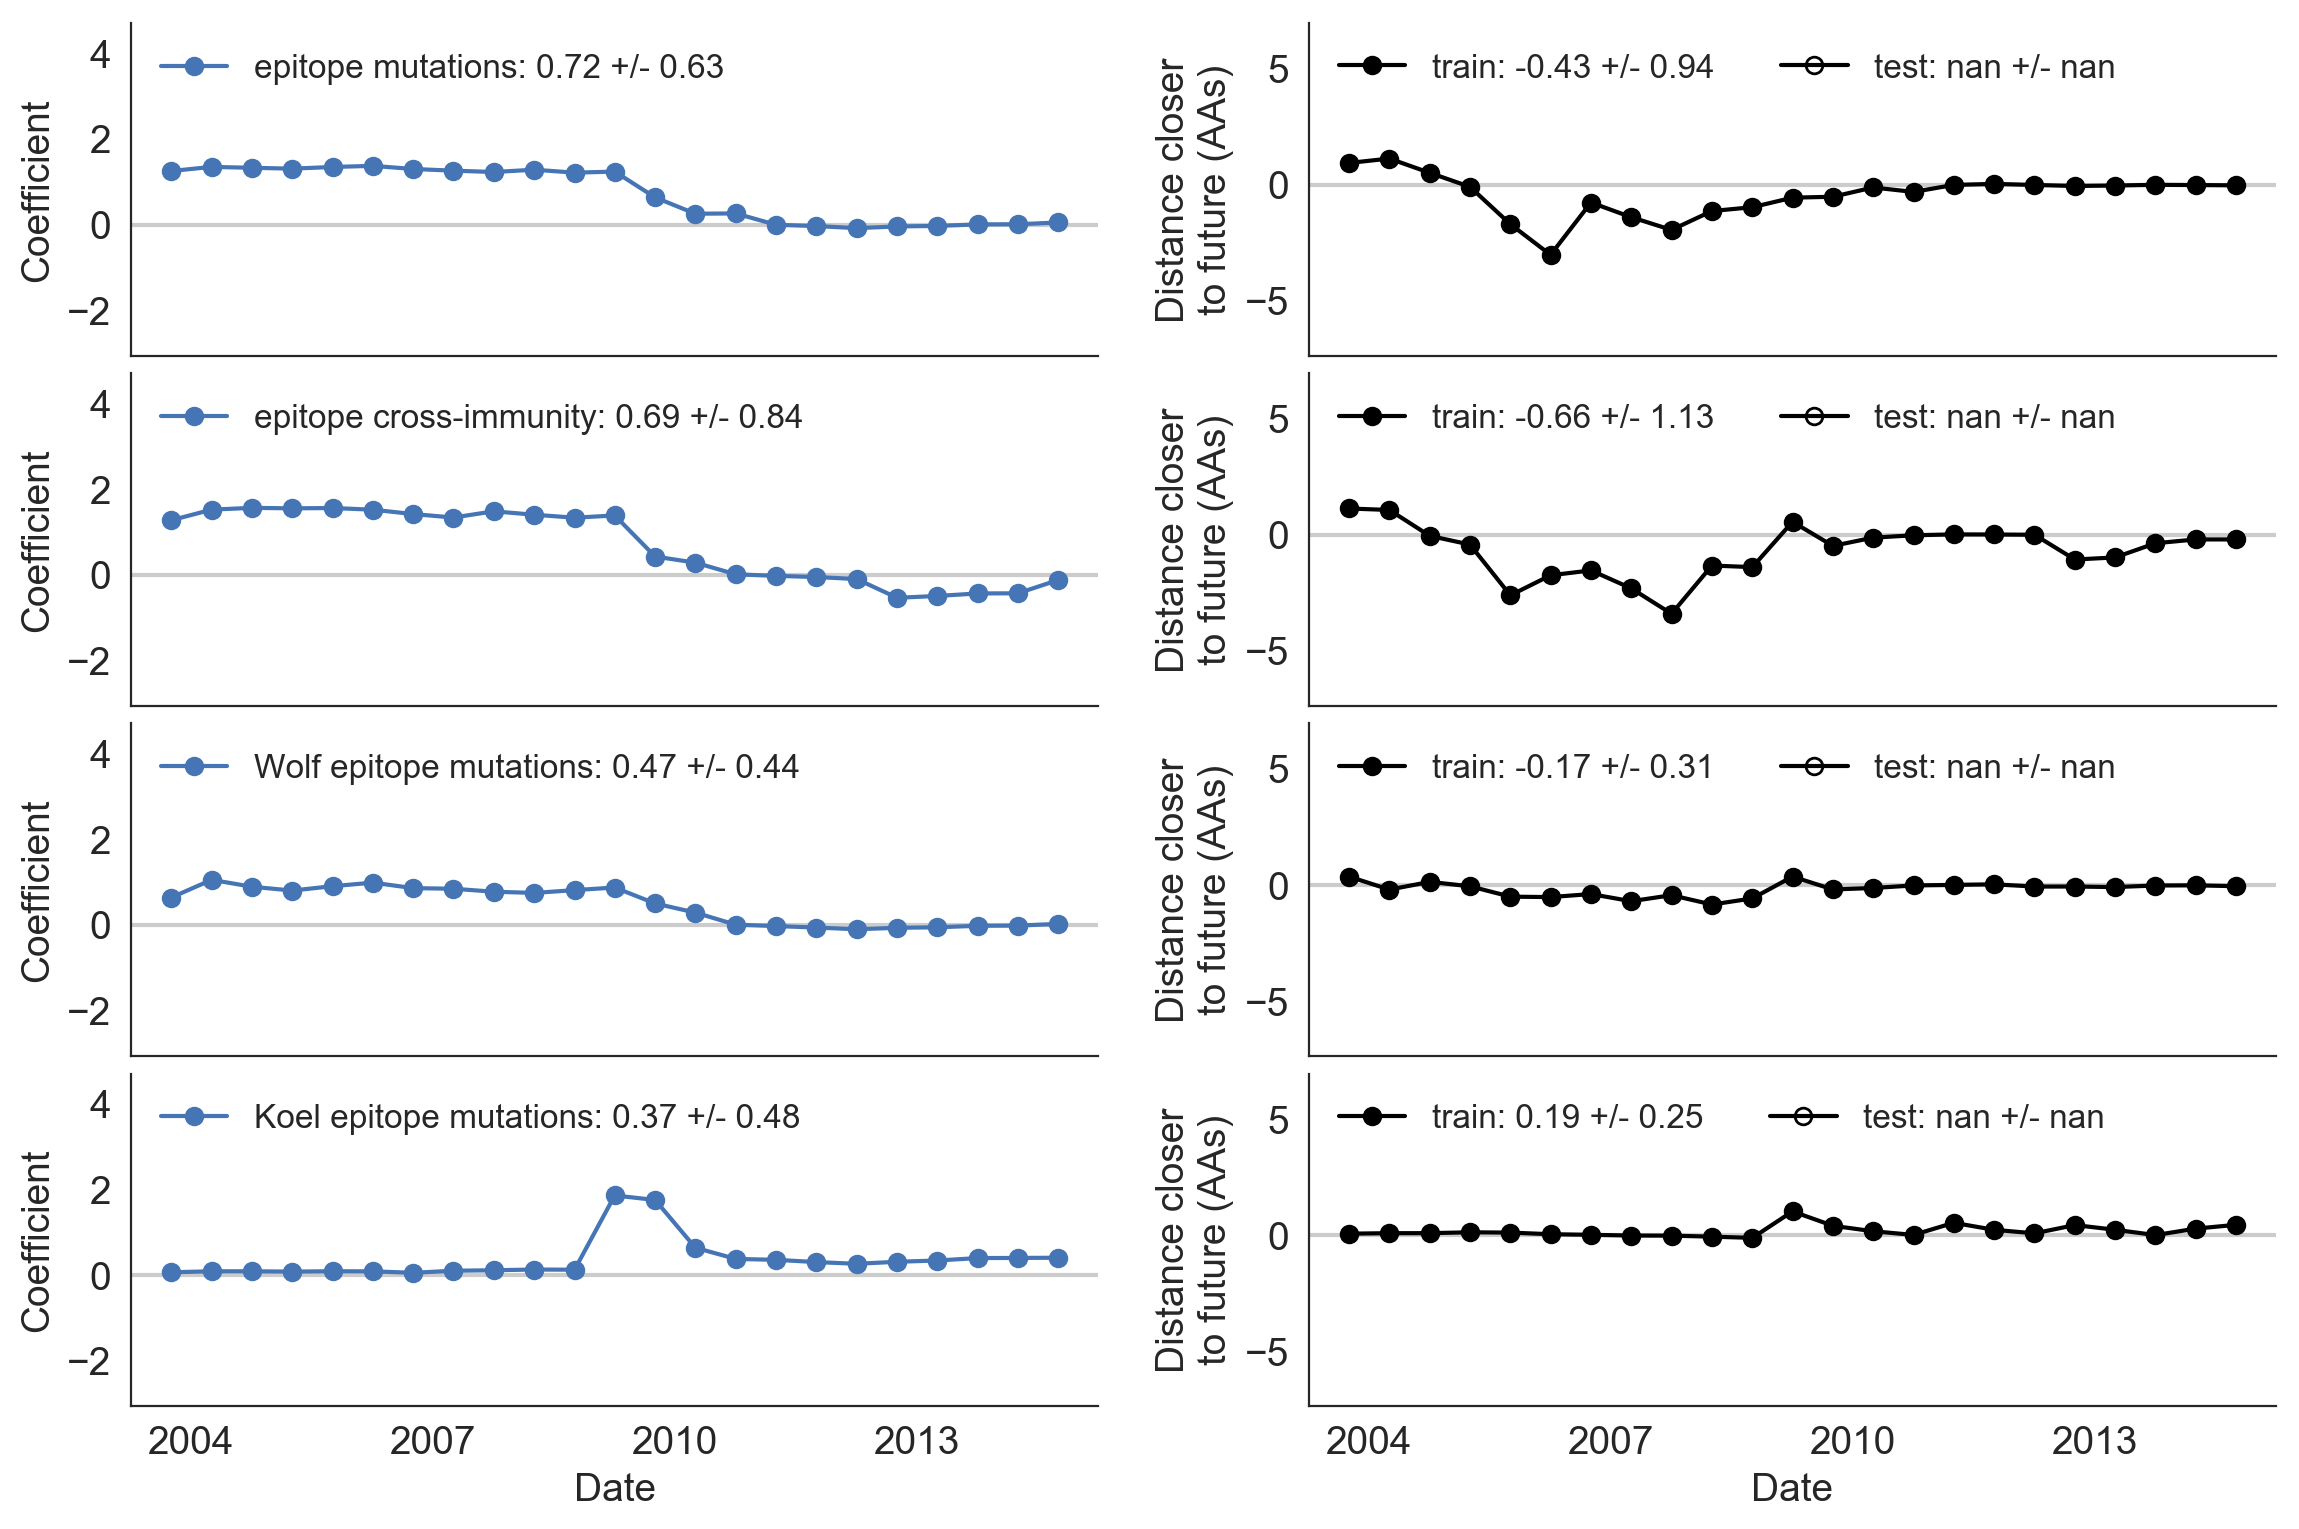

In [212]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["ep", "ep_x", "ep_wolf", "rb"],
    height=8,
    rotation=0
)
plt.savefig("../manuscript/figures/unadjusted-epitope-model-accuracy-and-coefficients-for-natural-populations.png")

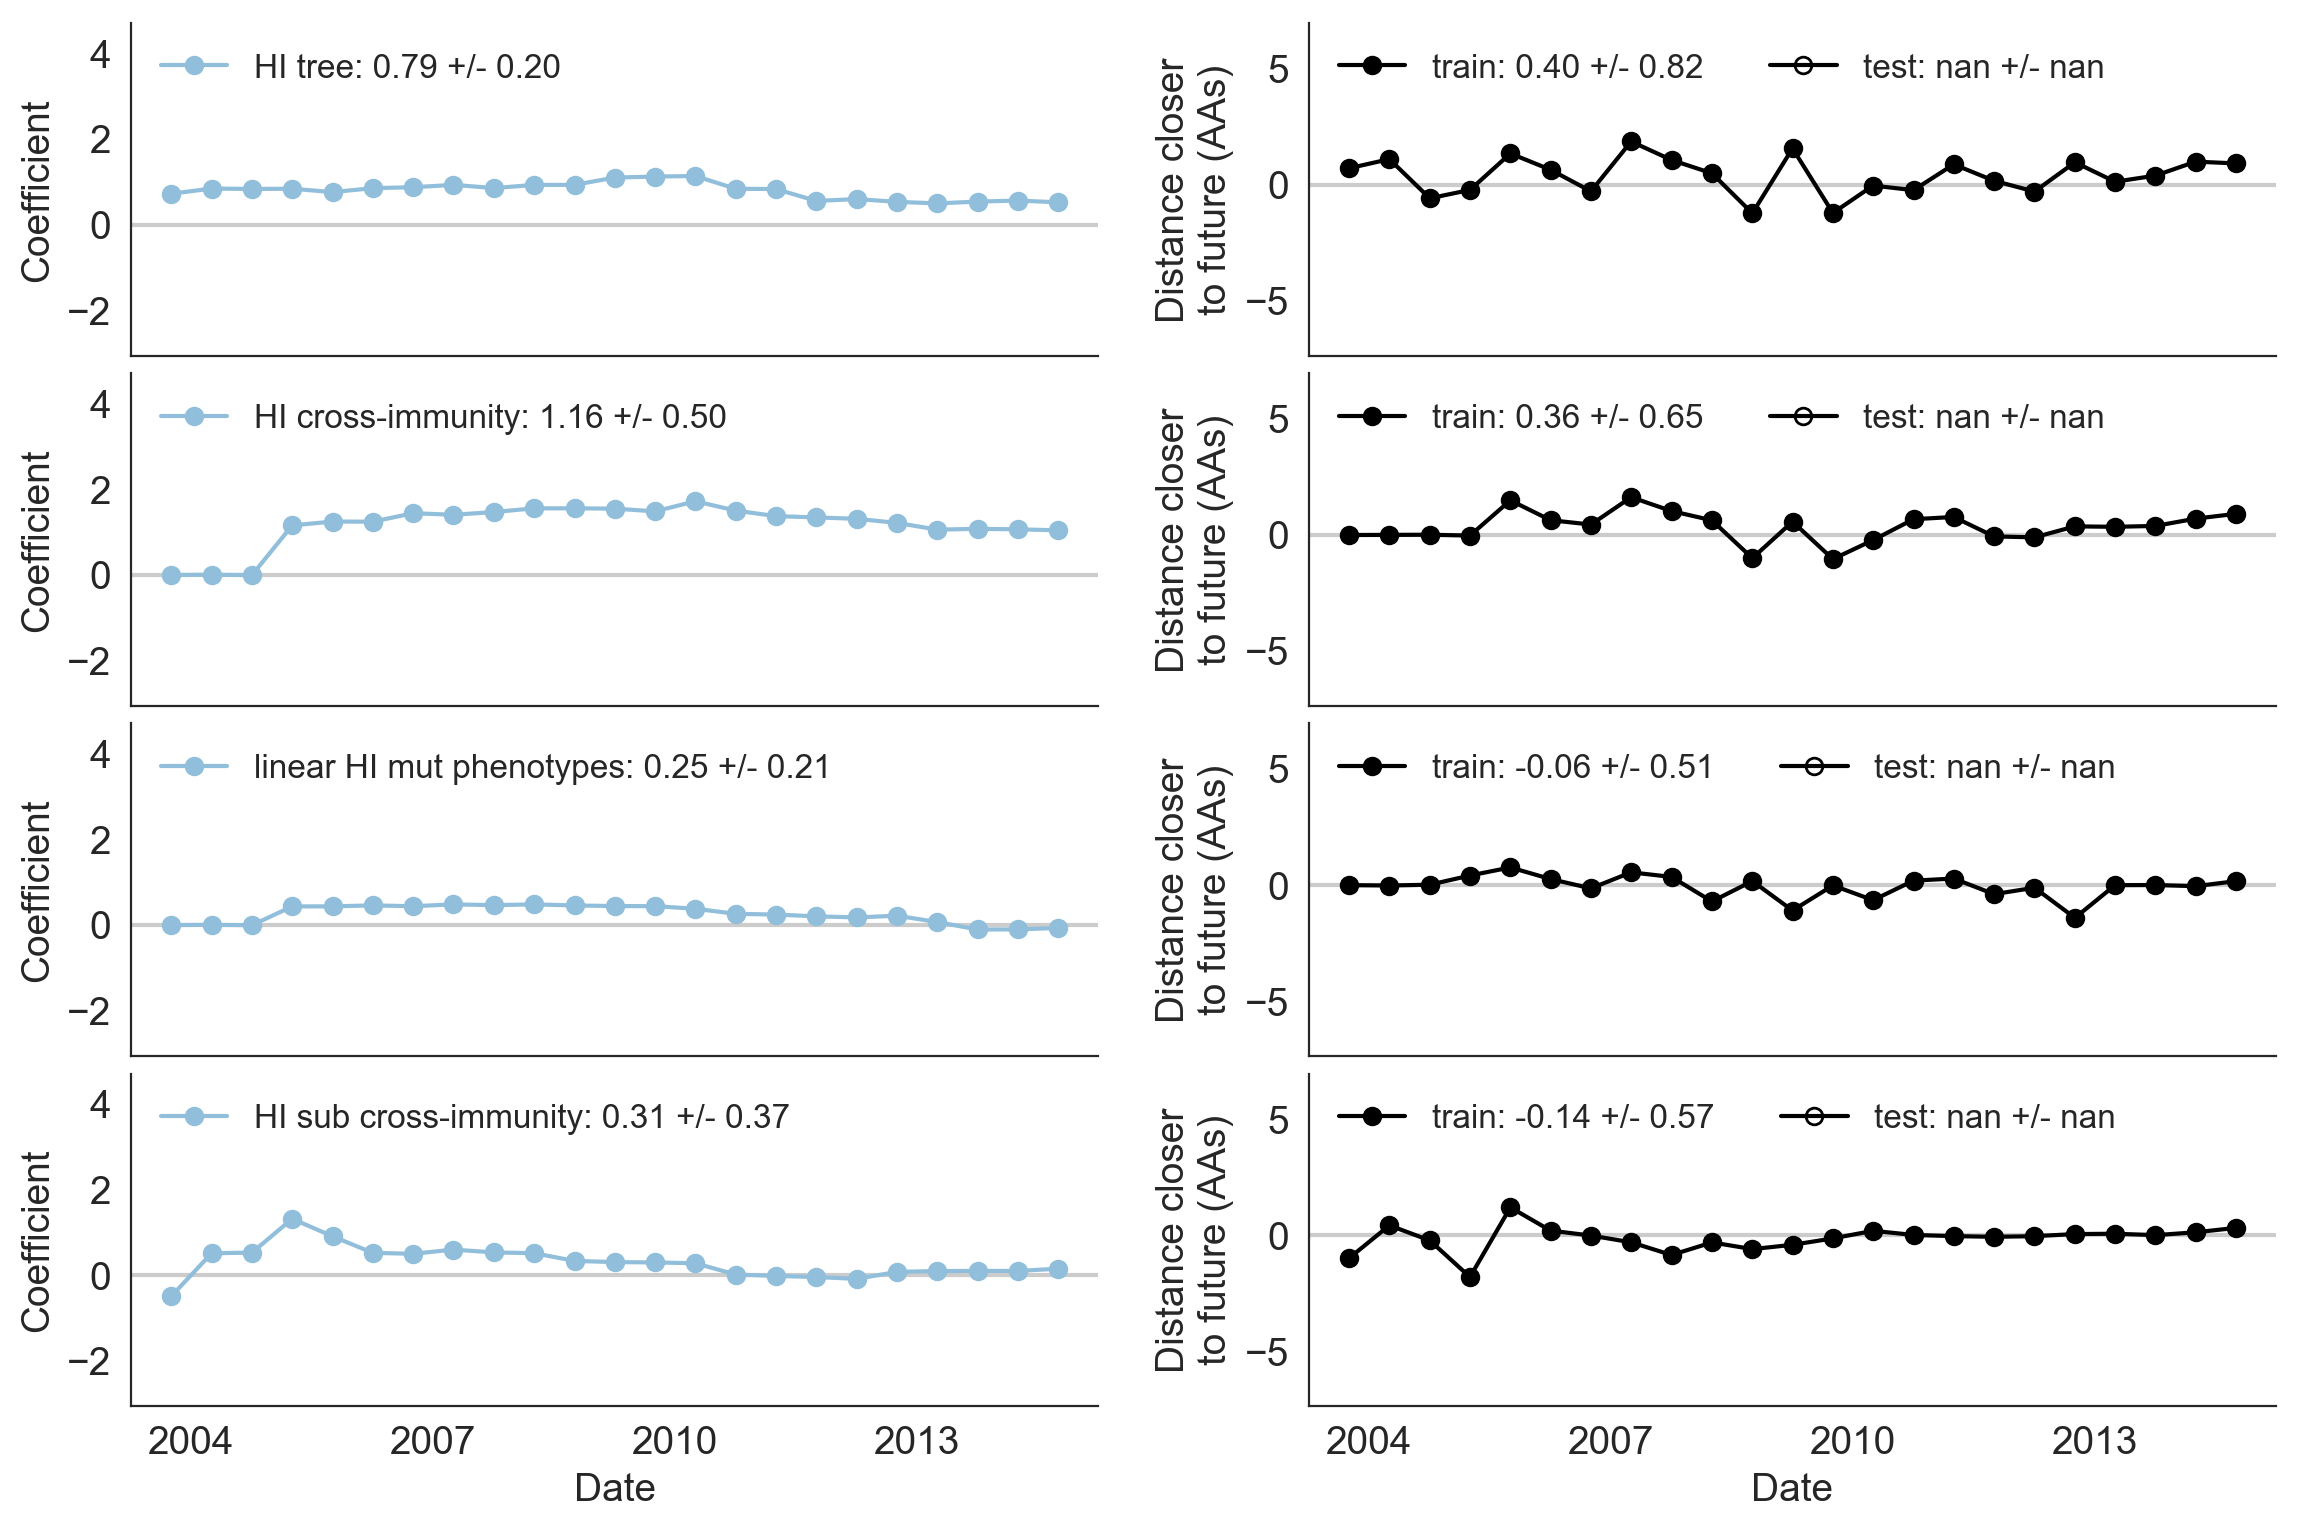

In [213]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["cTiter", "cTiter_x", "cTiterSub", "cTiterSub_x"],
    height=8,
    rotation=0
)
plt.savefig("../manuscript/figures/unadjusted-HI-model-accuracy-and-coefficients-for-natural-populations.png")

#### Functional

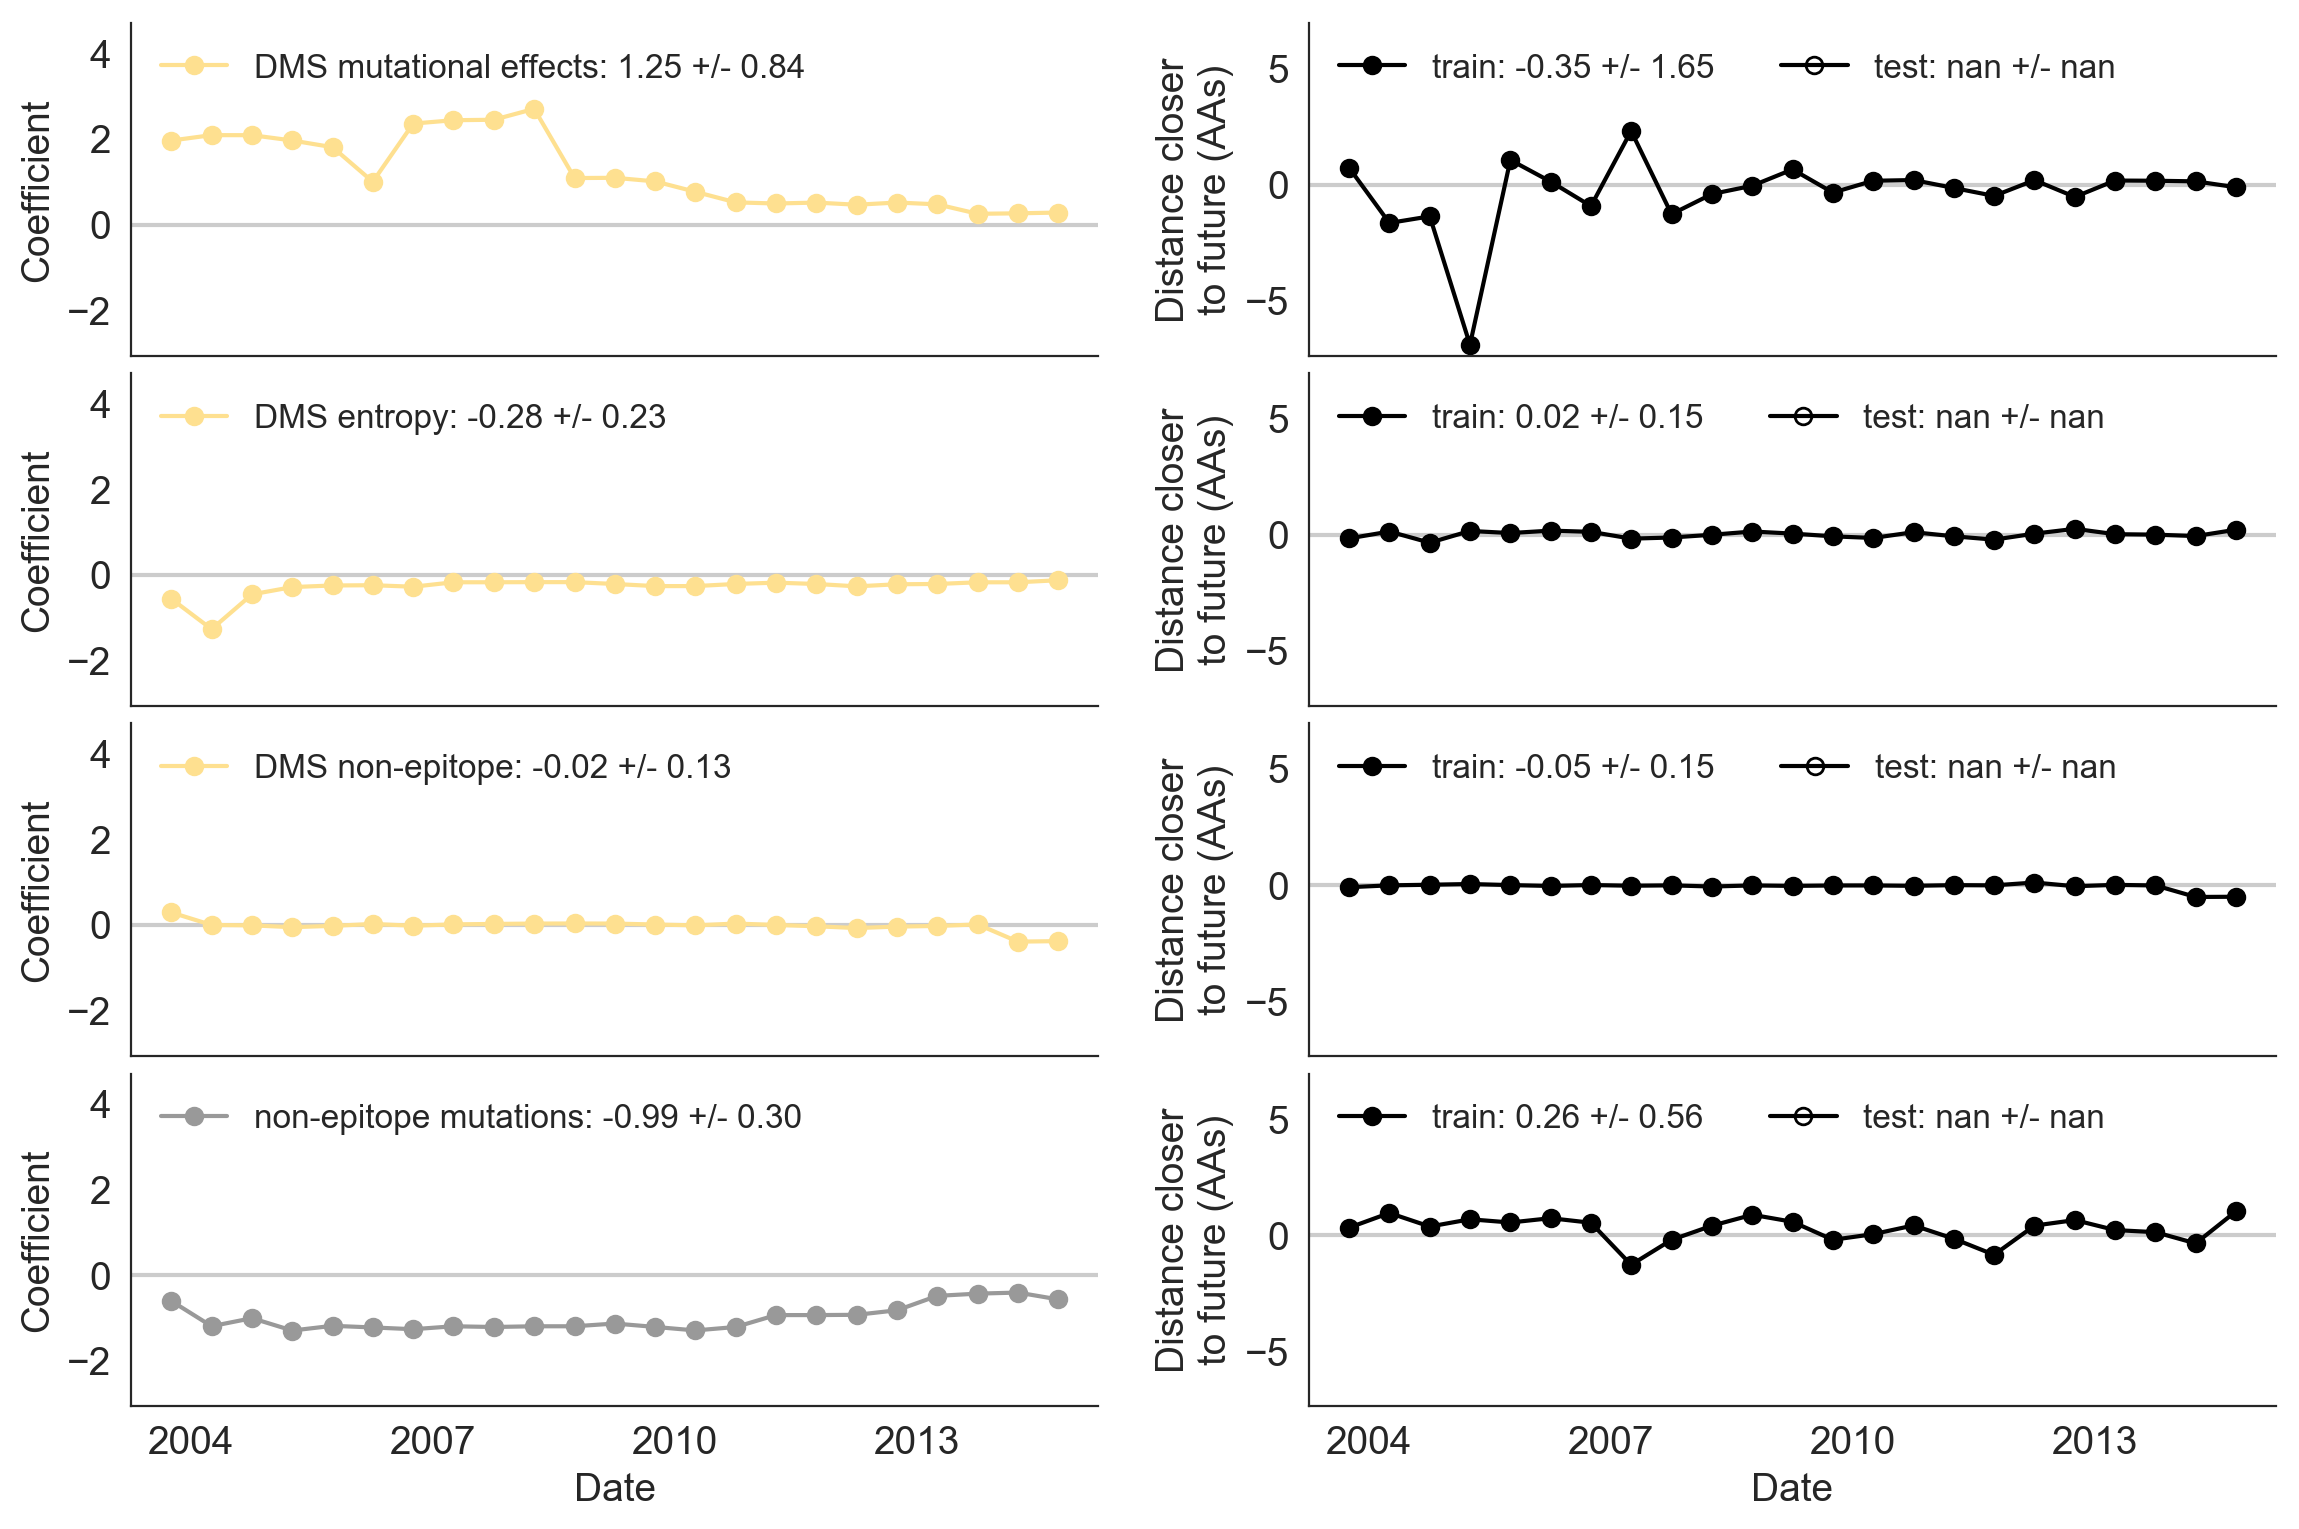

In [216]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["dms_star", "dms_entropy", "dms_nonepitope", "ne_star"],
    height=8,
    rotation=0
)
plt.savefig("../manuscript/figures/unadjusted-DMS-model-accuracy-and-coefficients-for-natural-populations.png")

#### All categories

In [ ]:
within_category_composite_predictors = [
    "ep_x-cTiter_x",
    "ne_star-dms_star",
    "lbi-delta_frequency"
]

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    within_category_composite_predictors,
    height=6,
    text_vertical_padding=0.15
)
plt.savefig("../manuscript/figures/within-category-composite-unadjusted-model-accuracy-and-coefficients-for-natural-populations.png")

### Composite models

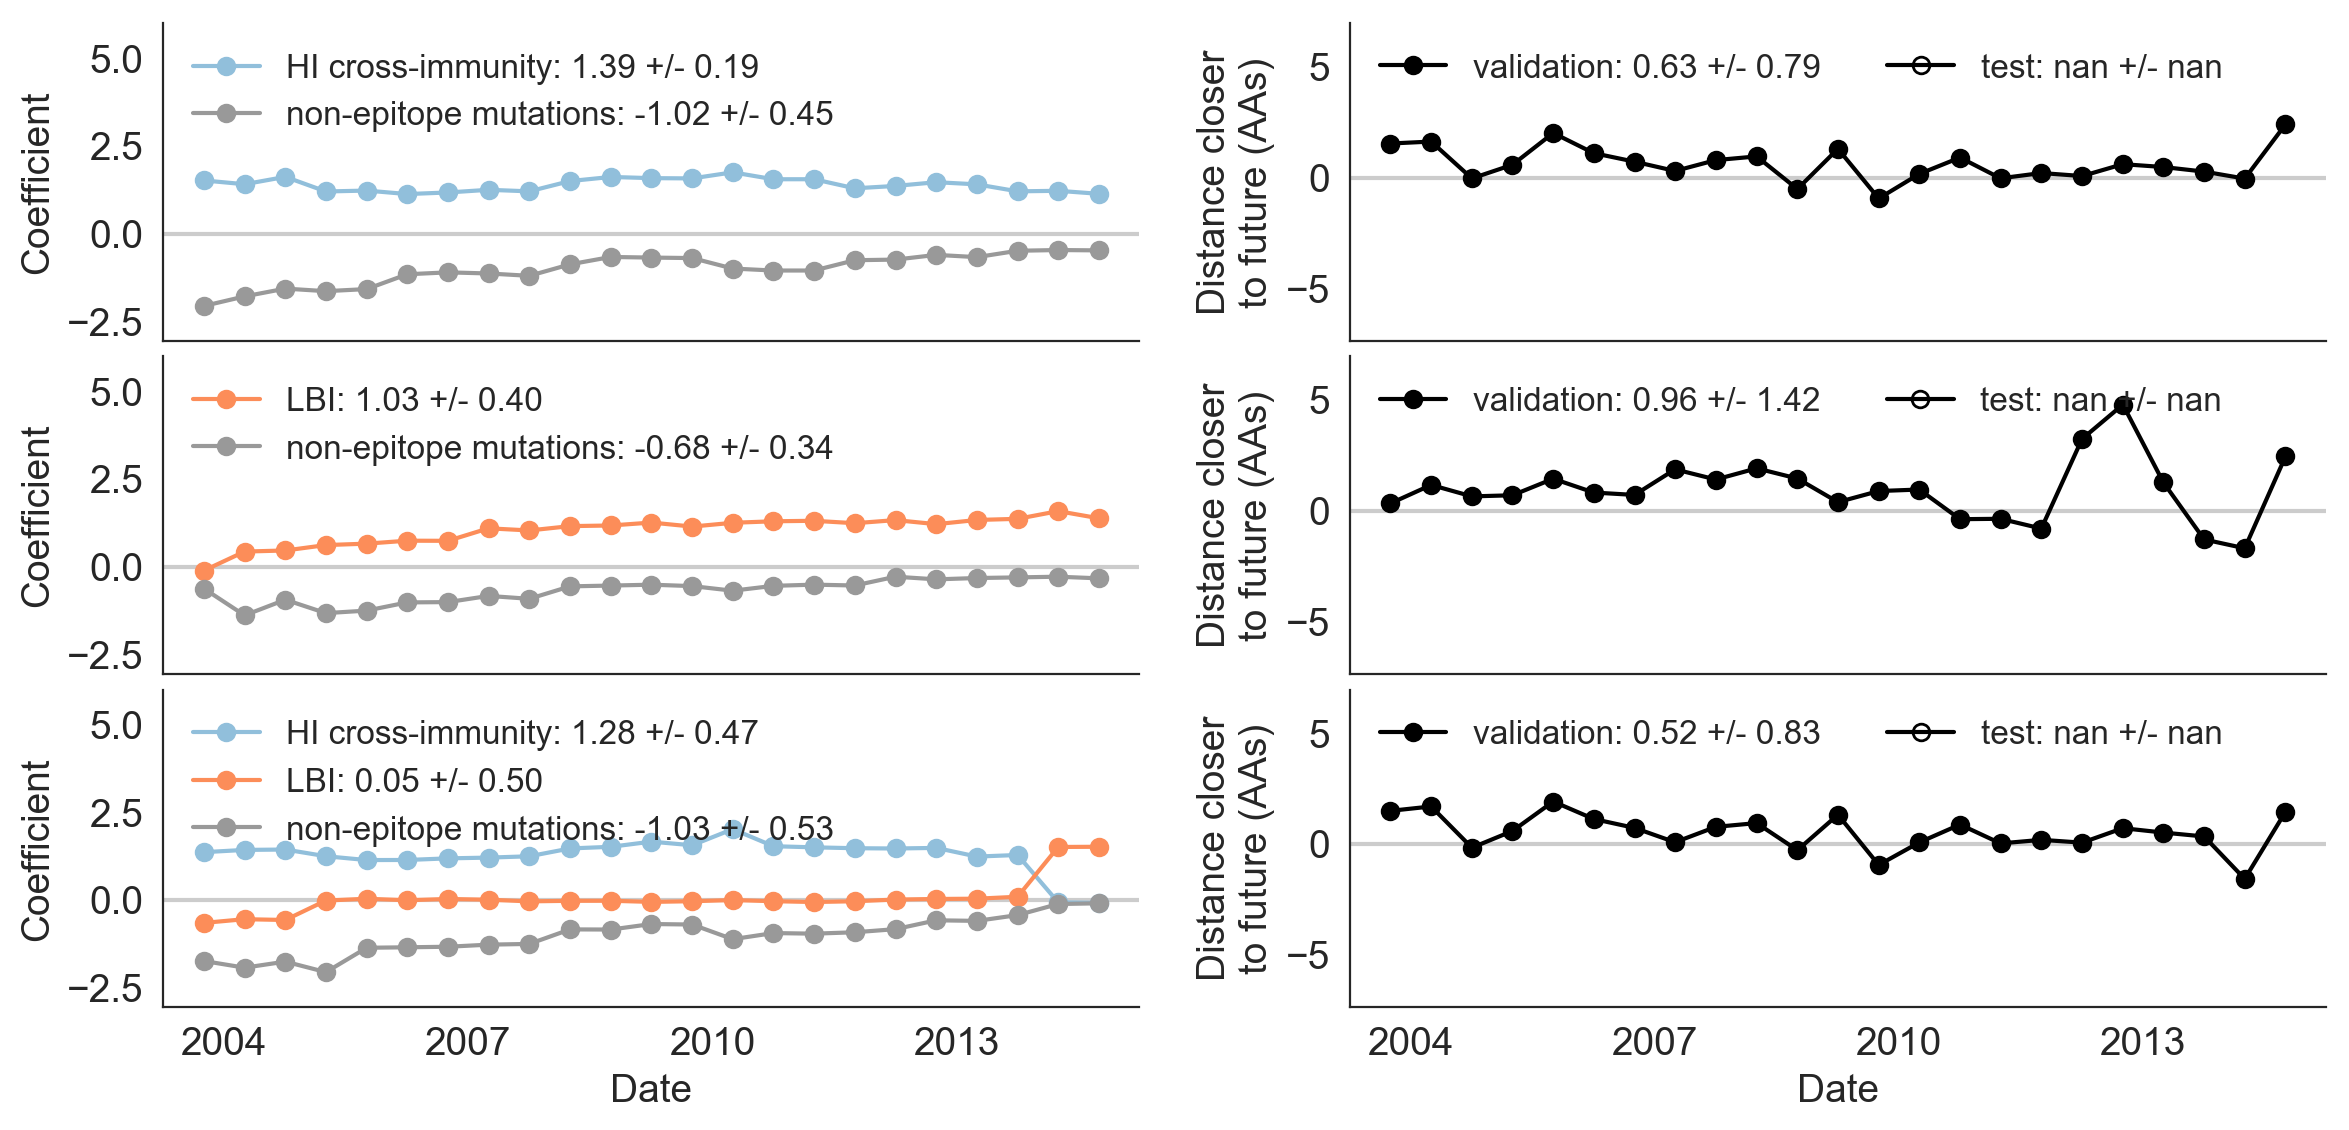

In [289]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    composite_models,
    height=6,
    text_vertical_padding=0.12,
    max_coefficient=6,
    rotation=0
)
plt.savefig("../manuscript/figures/best-composite-unadjusted-model-accuracy-and-coefficients-for-natural-populations.png")

### Best three-metric composite models

In [ ]:
best_three_metric_model = [
    "lbi-cTiter_x-ne_star",
    "delta_frequency-cTiter_x-ne_star"
]

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    best_three_metric_model,
    height=5
)
#plt.savefig("../manuscript/figures/best-three-metric-unadjusted-model-accuracy-and-coefficients-for-natural-populations.png")

In [ ]:
naive_error_df.head()

In [ ]:
naive_error_df.tail()

Calculate sum of differences between the estimated distances from the naive model and each biological model. The higher sum per model, the more the biological model outperforms the naive model.

In [ ]:
naive_error_df = errors_by_time_df[errors_by_time_df["predictors"] == "naive"].copy()

In [ ]:
natural_errors_by_time_with_naive_df = natural_errors_by_time_df.merge(
    naive_error_df,
    on=["validation_timepoint", "validation_n", "type", "sample"],
    suffixes=["_model", "_naive"]
)

In [ ]:
natural_errors_by_time_with_naive_df["model_gain"] = (
    natural_errors_by_time_with_naive_df["validation_error_naive"] - natural_errors_by_time_with_naive_df["validation_error_model"]
)

In [ ]:
natural_errors_by_time_with_naive_df.head()

In [ ]:
natural_errors_by_time_with_naive_df.groupby("predictors_model")["model_gain"].sum().sort_values(ascending=False)

## Figure 4: Summary of models for Luksza and Lassig populations

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    luksza_errors_by_time_df,
    luksza_coefficients_by_time_df,
    get_individual_predictors_for_data_frame(luksza_errors_by_time_df),
    height=6
)
#plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-luksza-lassig-populations.png")

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    luksza_errors_by_time_df,
    luksza_coefficients_by_time_df,
    ["lbi", "ep_x", "ne_star"] + get_composite_predictors_for_data_frame(luksza_errors_by_time_df)
)
#plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-luksza-lassig-populations.png")